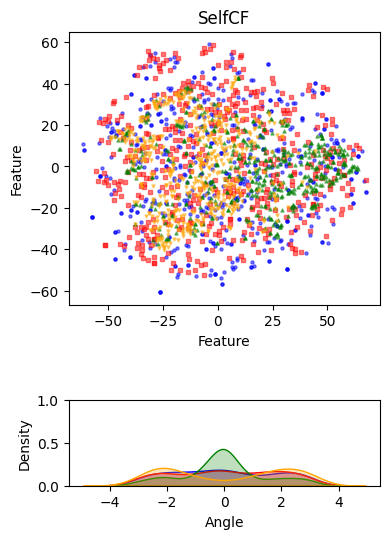

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
from sklearn.manifold import TSNE
import seaborn as sns
import random

np.random.seed(42)
random.seed(42)
torch.manual_seed(42)

# Load data
train_data = pd.read_csv('./dataset/douban-book/train.txt', delim_whitespace=True, header=None, names=['user_id', 'item_id', 'interaction'])
test_data = pd.read_csv('./dataset/douban-book/test.txt', delim_whitespace=True, header=None, names=['user_id', 'item_id', 'interaction'])
# user_emb = torch.load('./embedding/base/SelfCF_douban-book/best_user_emb.pt', map_location=torch.device('cpu'))
# item_emb = torch.load('./embedding/base/SelfCF_douban-book/best_item_emb.pt', map_location=torch.device('cpu'))

best_p_u = torch.load('./embedding/base/SelfCF_douban-book/best_p_u.pt', map_location=torch.device('cpu'))
best_u = torch.load('./embedding/base/SelfCF_douban-book/best_u.pt', map_location=torch.device('cpu'))
best_p_i = torch.load('./embedding/base/SelfCF_douban-book/best_p_i.pt', map_location=torch.device('cpu'))
best_i = torch.load('./embedding/base/SelfCF_douban-book/best_i.pt', map_location=torch.device('cpu'))

# Creating combined embeddings
user_emb = best_p_u + best_u
item_emb = best_p_i + best_i

# Calculate popularity
combined_data = pd.concat([train_data, test_data])
user_popularity = combined_data.groupby('user_id')['interaction'].sum().reset_index()
item_popularity = combined_data.groupby('item_id')['interaction'].sum().reset_index()

# Define thresholds for hot and cold sampling
user_hot_threshold = user_popularity['interaction'].quantile(0.95)
user_cold_threshold = user_popularity['interaction'].quantile(0.80)
item_hot_threshold = item_popularity['interaction'].quantile(0.95)
item_cold_threshold = item_popularity['interaction'].quantile(0.80)

# Sample hot and cold users/items
hot_users = user_popularity[user_popularity['interaction'] > user_hot_threshold].sample(500, replace=True)
cold_users = user_popularity[user_popularity['interaction'] <= user_cold_threshold].sample(500, replace=True)
hot_items = item_popularity[item_popularity['interaction'] > item_hot_threshold].sample(500, replace=True)
cold_items = item_popularity[item_popularity['interaction'] <= item_cold_threshold].sample(500, replace=True)

# Ensure that user and item ids are within the valid index range
valid_user_ids = hot_users['user_id'].apply(lambda x: x < user_emb.shape[0])
valid_item_ids = hot_items['item_id'].apply(lambda x: x < item_emb.shape[0])

hot_users = hot_users[valid_user_ids]
hot_items = hot_items[valid_item_ids]

valid_user_ids = cold_users['user_id'].apply(lambda x: x < user_emb.shape[0])
valid_item_ids = cold_items['item_id'].apply(lambda x: x < item_emb.shape[0])

cold_users = cold_users[valid_user_ids]
cold_items = cold_items[valid_item_ids]

# Now extract embeddings
hot_user_emb = user_emb[hot_users['user_id'].values]
cold_user_emb = user_emb[cold_users['user_id'].values]
hot_item_emb = item_emb[hot_items['item_id'].values]
cold_item_emb = item_emb[cold_items['item_id'].values]



# Combine and map to 2D using t-SNE
combined_user_emb = torch.cat([hot_user_emb, cold_user_emb])
combined_item_emb = torch.cat([hot_item_emb, cold_item_emb])
tsne = TSNE(n_components=2, random_state=42)
# user_emb_2d = tsne.fit_transform(combined_user_emb)
user_emb_2d = tsne.fit_transform(combined_user_emb.detach().numpy())
item_emb_2d = tsne.fit_transform(combined_item_emb.detach().numpy())

angles_hot_users = np.arctan2(user_emb_2d[:500, 1], user_emb_2d[:500, 0])
angles_cold_users = np.arctan2(user_emb_2d[500:, 1], user_emb_2d[500:, 0])
angles_hot_items = np.arctan2(item_emb_2d[:500, 1], item_emb_2d[:500, 0])
angles_cold_items = np.arctan2(item_emb_2d[500:, 1], item_emb_2d[500:, 0])

# Create a new figure for both the scatter and KDE plots
plt.figure(figsize=(4, 6))

plt.subplot(2, 1, 1)
plt.scatter(user_emb_2d[:500, 0], user_emb_2d[:500, 1], s=5, alpha=0.5, label='Hot Users', color='blue', marker='o')
plt.scatter(user_emb_2d[500:, 0], user_emb_2d[500:, 1], s=5, alpha=0.5, label='Cold Users', color='red', marker='s')
plt.scatter(item_emb_2d[:500, 0], item_emb_2d[:500, 1], s=5, alpha=0.5, label='Hot Items', color='green', marker='^')
plt.scatter(item_emb_2d[500:, 0], item_emb_2d[500:, 1], s=5, alpha=0.5, label='Cold Items', color='orange', marker='v')

plt.title("SelfCF")
plt.xlabel("Feature")
plt.ylabel("Feature")
# plt.legend()

# Plot KDE for angles
plt.subplot(2, 1, 2, aspect=3)
sns.kdeplot(angles_hot_users, fill=True, color='blue', label='Hot Users')  # dark gray
sns.kdeplot(angles_cold_users, fill=True, color='red', label='Cold Users')  # medium-dark gray
sns.kdeplot(angles_hot_items, fill=True, color='green', label='Hot Items')  # medium-light gray
sns.kdeplot(angles_cold_items, fill=True, color='orange', label='Cold Items')  # light gray

# Labeling the plot
# plt.title("KDE of atan2(y, x) for Each Group")
plt.xlabel("Angle")
plt.ylabel("Density")
plt.ylim(0, 1)
# plt.legend()

plt.tight_layout()
plt.savefig('/Users/mean/Downloads/ThinGCN/embedding/base/SelfCF_douban-book/SelfCF.png')
plt.show()

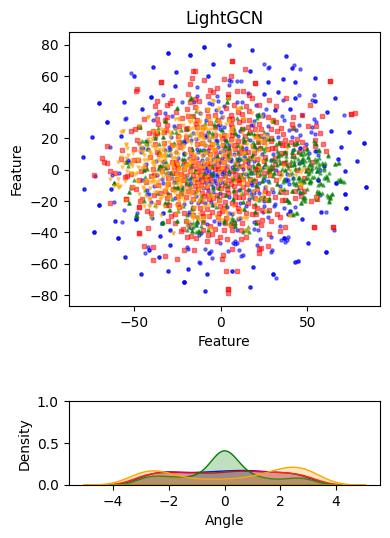

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
from sklearn.manifold import TSNE
import seaborn as sns
import random

np.random.seed(42)
random.seed(42)
torch.manual_seed(42)

# Load data
train_data = pd.read_csv('./dataset/douban-book/train.txt', delim_whitespace=True, header=None, names=['user_id', 'item_id', 'interaction'])
test_data = pd.read_csv('./dataset/douban-book/test.txt', delim_whitespace=True, header=None, names=['user_id', 'item_id', 'interaction'])
user_emb = torch.load('./embedding/base/LightGCN_douban-book/best_user_emb.pt', map_location=torch.device('cpu'))
item_emb = torch.load('./embedding/base/LightGCN_douban-book/best_item_emb.pt', map_location=torch.device('cpu'))

# Calculate popularity
combined_data = pd.concat([train_data, test_data])
user_popularity = combined_data.groupby('user_id')['interaction'].sum().reset_index()
item_popularity = combined_data.groupby('item_id')['interaction'].sum().reset_index()

# Define thresholds for hot and cold sampling
user_hot_threshold = user_popularity['interaction'].quantile(0.95)
user_cold_threshold = user_popularity['interaction'].quantile(0.80)
item_hot_threshold = item_popularity['interaction'].quantile(0.95)
item_cold_threshold = item_popularity['interaction'].quantile(0.80)

# Sample hot and cold users/items
hot_users = user_popularity[user_popularity['interaction'] > user_hot_threshold].sample(500, replace=True)
cold_users = user_popularity[user_popularity['interaction'] <= user_cold_threshold].sample(500, replace=True)
hot_items = item_popularity[item_popularity['interaction'] > item_hot_threshold].sample(500, replace=True)
cold_items = item_popularity[item_popularity['interaction'] <= item_cold_threshold].sample(500, replace=True)

# Ensure that user and item ids are within the valid index range
valid_user_ids = hot_users['user_id'].apply(lambda x: x < user_emb.shape[0])
valid_item_ids = hot_items['item_id'].apply(lambda x: x < item_emb.shape[0])

hot_users = hot_users[valid_user_ids]
hot_items = hot_items[valid_item_ids]

valid_user_ids = cold_users['user_id'].apply(lambda x: x < user_emb.shape[0])
valid_item_ids = cold_items['item_id'].apply(lambda x: x < item_emb.shape[0])

cold_users = cold_users[valid_user_ids]
cold_items = cold_items[valid_item_ids]

# Now extract embeddings
hot_user_emb = user_emb[hot_users['user_id'].values]
cold_user_emb = user_emb[cold_users['user_id'].values]
hot_item_emb = item_emb[hot_items['item_id'].values]
cold_item_emb = item_emb[cold_items['item_id'].values]



# Combine and map to 2D using t-SNE
combined_user_emb = torch.cat([hot_user_emb, cold_user_emb])
combined_item_emb = torch.cat([hot_item_emb, cold_item_emb])
tsne = TSNE(n_components=2, random_state=42)
# user_emb_2d = tsne.fit_transform(combined_user_emb)
user_emb_2d = tsne.fit_transform(combined_user_emb.detach().numpy())
item_emb_2d = tsne.fit_transform(combined_item_emb.detach().numpy())

angles_hot_users = np.arctan2(user_emb_2d[:500, 1], user_emb_2d[:500, 0])
angles_cold_users = np.arctan2(user_emb_2d[500:, 1], user_emb_2d[500:, 0])
angles_hot_items = np.arctan2(item_emb_2d[:500, 1], item_emb_2d[:500, 0])
angles_cold_items = np.arctan2(item_emb_2d[500:, 1], item_emb_2d[500:, 0])

# Create a new figure for both the scatter and KDE plots
plt.figure(figsize=(4, 6))

plt.subplot(2, 1, 1)
plt.scatter(user_emb_2d[:500, 0], user_emb_2d[:500, 1], s=5, alpha=0.5, label='Hot Users', color='blue', marker='o')
plt.scatter(user_emb_2d[500:, 0], user_emb_2d[500:, 1], s=5, alpha=0.5, label='Cold Users', color='red', marker='s')
plt.scatter(item_emb_2d[:500, 0], item_emb_2d[:500, 1], s=5, alpha=0.5, label='Hot Items', color='green', marker='^')
plt.scatter(item_emb_2d[500:, 0], item_emb_2d[500:, 1], s=5, alpha=0.5, label='Cold Items', color='orange', marker='v')

plt.title("LightGCN")
plt.xlabel("Feature")
plt.ylabel("Feature")
# plt.legend()

# Plot KDE for angles
plt.subplot(2, 1, 2, aspect=3)
sns.kdeplot(angles_hot_users, fill=True, color='blue', label='Hot Users')  # dark gray
sns.kdeplot(angles_cold_users, fill=True, color='red', label='Cold Users')  # medium-dark gray
sns.kdeplot(angles_hot_items, fill=True, color='green', label='Hot Items')  # medium-light gray
sns.kdeplot(angles_cold_items, fill=True, color='orange', label='Cold Items')  # light gray

# Labeling the plot
# plt.title("KDE of atan2(y, x) for Each Group")
plt.xlabel("Angle")
plt.ylabel("Density")
plt.ylim(0, 1)
# plt.legend()

plt.tight_layout()
plt.savefig('/Users/mean/Downloads/ThinGCN/embedding/base/LightGCN_douban-book/LightGCN.png')
plt.show()

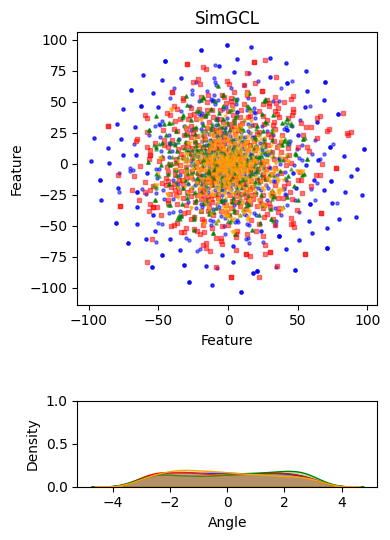

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
from sklearn.manifold import TSNE
import seaborn as sns
import random

np.random.seed(42)
random.seed(42)
torch.manual_seed(42)

# Load data
train_data = pd.read_csv('./dataset/douban-book/train.txt', delim_whitespace=True, header=None, names=['user_id', 'item_id', 'interaction'])
test_data = pd.read_csv('./dataset/douban-book/test.txt', delim_whitespace=True, header=None, names=['user_id', 'item_id', 'interaction'])
user_emb = torch.load('./embedding/base/SimGCL_douban-book/best_user_emb.pt', map_location=torch.device('cpu'))
item_emb = torch.load('./embedding/base/SimGCL_douban-book/best_item_emb.pt', map_location=torch.device('cpu'))

# Calculate popularity
combined_data = pd.concat([train_data, test_data])
user_popularity = combined_data.groupby('user_id')['interaction'].sum().reset_index()
item_popularity = combined_data.groupby('item_id')['interaction'].sum().reset_index()

# Define thresholds for hot and cold sampling
user_hot_threshold = user_popularity['interaction'].quantile(0.95)
user_cold_threshold = user_popularity['interaction'].quantile(0.80)
item_hot_threshold = item_popularity['interaction'].quantile(0.95)
item_cold_threshold = item_popularity['interaction'].quantile(0.80)

# Sample hot and cold users/items
hot_users = user_popularity[user_popularity['interaction'] > user_hot_threshold].sample(500, replace=True)
cold_users = user_popularity[user_popularity['interaction'] <= user_cold_threshold].sample(500, replace=True)
hot_items = item_popularity[item_popularity['interaction'] > item_hot_threshold].sample(500, replace=True)
cold_items = item_popularity[item_popularity['interaction'] <= item_cold_threshold].sample(500, replace=True)

# Ensure that user and item ids are within the valid index range
valid_user_ids = hot_users['user_id'].apply(lambda x: x < user_emb.shape[0])
valid_item_ids = hot_items['item_id'].apply(lambda x: x < item_emb.shape[0])

hot_users = hot_users[valid_user_ids]
hot_items = hot_items[valid_item_ids]

valid_user_ids = cold_users['user_id'].apply(lambda x: x < user_emb.shape[0])
valid_item_ids = cold_items['item_id'].apply(lambda x: x < item_emb.shape[0])

cold_users = cold_users[valid_user_ids]
cold_items = cold_items[valid_item_ids]

# Now extract embeddings
hot_user_emb = user_emb[hot_users['user_id'].values]
cold_user_emb = user_emb[cold_users['user_id'].values]
hot_item_emb = item_emb[hot_items['item_id'].values]
cold_item_emb = item_emb[cold_items['item_id'].values]



# Combine and map to 2D using t-SNE
combined_user_emb = torch.cat([hot_user_emb, cold_user_emb])
combined_item_emb = torch.cat([hot_item_emb, cold_item_emb])
tsne = TSNE(n_components=2, random_state=42)
# user_emb_2d = tsne.fit_transform(combined_user_emb)
user_emb_2d = tsne.fit_transform(combined_user_emb.detach().numpy())
item_emb_2d = tsne.fit_transform(combined_item_emb.detach().numpy())

angles_hot_users = np.arctan2(user_emb_2d[:500, 1], user_emb_2d[:500, 0])
angles_cold_users = np.arctan2(user_emb_2d[500:, 1], user_emb_2d[500:, 0])
angles_hot_items = np.arctan2(item_emb_2d[:500, 1], item_emb_2d[:500, 0])
angles_cold_items = np.arctan2(item_emb_2d[500:, 1], item_emb_2d[500:, 0])

# Create a new figure for both the scatter and KDE plots
plt.figure(figsize=(4, 6))

plt.subplot(2, 1, 1)
plt.scatter(user_emb_2d[:500, 0], user_emb_2d[:500, 1], s=5, alpha=0.5, label='Hot Users', color='blue', marker='o')
plt.scatter(user_emb_2d[500:, 0], user_emb_2d[500:, 1], s=5, alpha=0.5, label='Cold Users', color='red', marker='s')
plt.scatter(item_emb_2d[:500, 0], item_emb_2d[:500, 1], s=5, alpha=0.5, label='Hot Items', color='green', marker='^')
plt.scatter(item_emb_2d[500:, 0], item_emb_2d[500:, 1], s=5, alpha=0.5, label='Cold Items', color='orange', marker='v')

plt.title("SimGCL")
plt.xlabel("Feature")
plt.ylabel("Feature")
# plt.legend()

# Plot KDE for angles
plt.subplot(2, 1, 2, aspect=3)
sns.kdeplot(angles_hot_users, fill=True, color='blue', label='Hot Users')  # dark gray
sns.kdeplot(angles_cold_users, fill=True, color='red', label='Cold Users')  # medium-dark gray
sns.kdeplot(angles_hot_items, fill=True, color='green', label='Hot Items')  # medium-light gray
sns.kdeplot(angles_cold_items, fill=True, color='orange', label='Cold Items')  # light gray

# Labeling the plot
# plt.title("KDE of atan2(y, x) for Each Group")
plt.xlabel("Angle")
plt.ylabel("Density")
plt.ylim(0, 1)
# plt.legend()

plt.tight_layout()
plt.savefig('/Users/mean/Downloads/ThinGCN/embedding/base/SimGCL_douban-book/SimGCL.png')
plt.show()

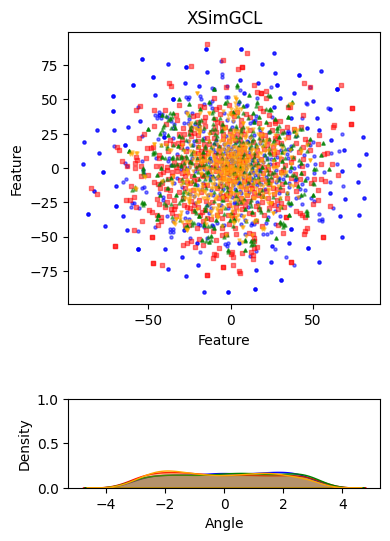

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
from sklearn.manifold import TSNE
import seaborn as sns
import random

np.random.seed(42)
random.seed(42)
torch.manual_seed(42)

# Load data
train_data = pd.read_csv('./dataset/douban-book/train.txt', delim_whitespace=True, header=None, names=['user_id', 'item_id', 'interaction'])
test_data = pd.read_csv('./dataset/douban-book/test.txt', delim_whitespace=True, header=None, names=['user_id', 'item_id', 'interaction'])
user_emb = torch.load('./embedding/base/XSimGCL_douban-book/best_user_emb.pt', map_location=torch.device('cpu'))
item_emb = torch.load('./embedding/base/XSimGCL_douban-book/best_item_emb.pt', map_location=torch.device('cpu'))

# Calculate popularity
combined_data = pd.concat([train_data, test_data])
user_popularity = combined_data.groupby('user_id')['interaction'].sum().reset_index()
item_popularity = combined_data.groupby('item_id')['interaction'].sum().reset_index()

# Define thresholds for hot and cold sampling
user_hot_threshold = user_popularity['interaction'].quantile(0.95)
user_cold_threshold = user_popularity['interaction'].quantile(0.80)
item_hot_threshold = item_popularity['interaction'].quantile(0.95)
item_cold_threshold = item_popularity['interaction'].quantile(0.80)

# Sample hot and cold users/items
hot_users = user_popularity[user_popularity['interaction'] > user_hot_threshold].sample(500, replace=True)
cold_users = user_popularity[user_popularity['interaction'] <= user_cold_threshold].sample(500, replace=True)
hot_items = item_popularity[item_popularity['interaction'] > item_hot_threshold].sample(500, replace=True)
cold_items = item_popularity[item_popularity['interaction'] <= item_cold_threshold].sample(500, replace=True)

# Ensure that user and item ids are within the valid index range
valid_user_ids = hot_users['user_id'].apply(lambda x: x < user_emb.shape[0])
valid_item_ids = hot_items['item_id'].apply(lambda x: x < item_emb.shape[0])

hot_users = hot_users[valid_user_ids]
hot_items = hot_items[valid_item_ids]

valid_user_ids = cold_users['user_id'].apply(lambda x: x < user_emb.shape[0])
valid_item_ids = cold_items['item_id'].apply(lambda x: x < item_emb.shape[0])

cold_users = cold_users[valid_user_ids]
cold_items = cold_items[valid_item_ids]

# Now extract embeddings
hot_user_emb = user_emb[hot_users['user_id'].values]
cold_user_emb = user_emb[cold_users['user_id'].values]
hot_item_emb = item_emb[hot_items['item_id'].values]
cold_item_emb = item_emb[cold_items['item_id'].values]



# Combine and map to 2D using t-SNE
combined_user_emb = torch.cat([hot_user_emb, cold_user_emb])
combined_item_emb = torch.cat([hot_item_emb, cold_item_emb])
tsne = TSNE(n_components=2, random_state=42)
# user_emb_2d = tsne.fit_transform(combined_user_emb)
user_emb_2d = tsne.fit_transform(combined_user_emb.detach().numpy())
item_emb_2d = tsne.fit_transform(combined_item_emb.detach().numpy())

angles_hot_users = np.arctan2(user_emb_2d[:500, 1], user_emb_2d[:500, 0])
angles_cold_users = np.arctan2(user_emb_2d[500:, 1], user_emb_2d[500:, 0])
angles_hot_items = np.arctan2(item_emb_2d[:500, 1], item_emb_2d[:500, 0])
angles_cold_items = np.arctan2(item_emb_2d[500:, 1], item_emb_2d[500:, 0])

# Create a new figure for both the scatter and KDE plots
plt.figure(figsize=(4, 6))

plt.subplot(2, 1, 1)
plt.scatter(user_emb_2d[:500, 0], user_emb_2d[:500, 1], s=5, alpha=0.5, label='Hot Users', color='blue', marker='o')
plt.scatter(user_emb_2d[500:, 0], user_emb_2d[500:, 1], s=5, alpha=0.5, label='Cold Users', color='red', marker='s')
plt.scatter(item_emb_2d[:500, 0], item_emb_2d[:500, 1], s=5, alpha=0.5, label='Hot Items', color='green', marker='^')
plt.scatter(item_emb_2d[500:, 0], item_emb_2d[500:, 1], s=5, alpha=0.5, label='Cold Items', color='orange', marker='v')

plt.title("XSimGCL")
plt.xlabel("Feature")
plt.ylabel("Feature")
# plt.legend()

# Plot KDE for angles
plt.subplot(2, 1, 2, aspect=3)
sns.kdeplot(angles_hot_users, fill=True, color='blue', label='Hot Users')  # dark gray
sns.kdeplot(angles_cold_users, fill=True, color='red', label='Cold Users')  # medium-dark gray
sns.kdeplot(angles_hot_items, fill=True, color='green', label='Hot Items')  # medium-light gray
sns.kdeplot(angles_cold_items, fill=True, color='orange', label='Cold Items')  # light gray

# Labeling the plot
# plt.title("KDE of atan2(y, x) for Each Group")
plt.xlabel("Angle")
plt.ylabel("Density")
plt.ylim(0, 1)
# plt.legend()

plt.tight_layout()
plt.savefig('/Users/mean/Downloads/ThinGCN/embedding/base/XSimGCL_douban-book/XSimGCL.png')
plt.show()

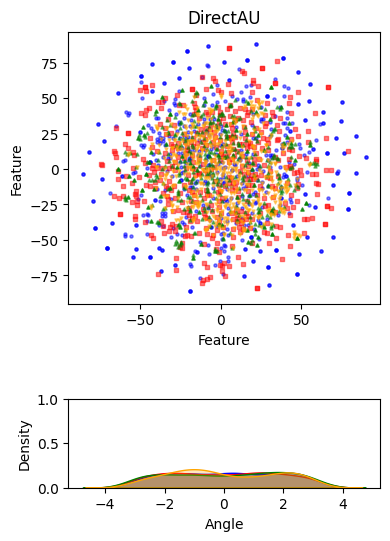

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
from sklearn.manifold import TSNE
import seaborn as sns
import random

np.random.seed(42)
random.seed(42)
torch.manual_seed(42)

# Load data
train_data = pd.read_csv('./dataset/douban-book/train.txt', delim_whitespace=True, header=None, names=['user_id', 'item_id', 'interaction'])
test_data = pd.read_csv('./dataset/douban-book/test.txt', delim_whitespace=True, header=None, names=['user_id', 'item_id', 'interaction'])
user_emb = torch.load('./embedding/base/DirectAU_douban-book/best_user_emb.pt', map_location=torch.device('cpu'))
item_emb = torch.load('./embedding/base/DirectAU_douban-book/best_item_emb.pt', map_location=torch.device('cpu'))

# Calculate popularity
combined_data = pd.concat([train_data, test_data])
user_popularity = combined_data.groupby('user_id')['interaction'].sum().reset_index()
item_popularity = combined_data.groupby('item_id')['interaction'].sum().reset_index()

# Define thresholds for hot and cold sampling
user_hot_threshold = user_popularity['interaction'].quantile(0.95)
user_cold_threshold = user_popularity['interaction'].quantile(0.80)
item_hot_threshold = item_popularity['interaction'].quantile(0.95)
item_cold_threshold = item_popularity['interaction'].quantile(0.80)

# Sample hot and cold users/items
hot_users = user_popularity[user_popularity['interaction'] > user_hot_threshold].sample(500, replace=True)
cold_users = user_popularity[user_popularity['interaction'] <= user_cold_threshold].sample(500, replace=True)
hot_items = item_popularity[item_popularity['interaction'] > item_hot_threshold].sample(500, replace=True)
cold_items = item_popularity[item_popularity['interaction'] <= item_cold_threshold].sample(500, replace=True)

# Ensure that user and item ids are within the valid index range
valid_user_ids = hot_users['user_id'].apply(lambda x: x < user_emb.shape[0])
valid_item_ids = hot_items['item_id'].apply(lambda x: x < item_emb.shape[0])

hot_users = hot_users[valid_user_ids]
hot_items = hot_items[valid_item_ids]

valid_user_ids = cold_users['user_id'].apply(lambda x: x < user_emb.shape[0])
valid_item_ids = cold_items['item_id'].apply(lambda x: x < item_emb.shape[0])

cold_users = cold_users[valid_user_ids]
cold_items = cold_items[valid_item_ids]

# Now extract embeddings
hot_user_emb = user_emb[hot_users['user_id'].values]
cold_user_emb = user_emb[cold_users['user_id'].values]
hot_item_emb = item_emb[hot_items['item_id'].values]
cold_item_emb = item_emb[cold_items['item_id'].values]



# Combine and map to 2D using t-SNE
combined_user_emb = torch.cat([hot_user_emb, cold_user_emb])
combined_item_emb = torch.cat([hot_item_emb, cold_item_emb])
tsne = TSNE(n_components=2, random_state=42)
# user_emb_2d = tsne.fit_transform(combined_user_emb)
user_emb_2d = tsne.fit_transform(combined_user_emb.detach().numpy())
item_emb_2d = tsne.fit_transform(combined_item_emb.detach().numpy())

angles_hot_users = np.arctan2(user_emb_2d[:500, 1], user_emb_2d[:500, 0])
angles_cold_users = np.arctan2(user_emb_2d[500:, 1], user_emb_2d[500:, 0])
angles_hot_items = np.arctan2(item_emb_2d[:500, 1], item_emb_2d[:500, 0])
angles_cold_items = np.arctan2(item_emb_2d[500:, 1], item_emb_2d[500:, 0])

# Create a new figure for both the scatter and KDE plots
plt.figure(figsize=(4, 6))

plt.subplot(2, 1, 1)
plt.scatter(user_emb_2d[:500, 0], user_emb_2d[:500, 1], s=5, alpha=0.5, label='Hot Users', color='blue', marker='o')
plt.scatter(user_emb_2d[500:, 0], user_emb_2d[500:, 1], s=5, alpha=0.5, label='Cold Users', color='red', marker='s')
plt.scatter(item_emb_2d[:500, 0], item_emb_2d[:500, 1], s=5, alpha=0.5, label='Hot Items', color='green', marker='^')
plt.scatter(item_emb_2d[500:, 0], item_emb_2d[500:, 1], s=5, alpha=0.5, label='Cold Items', color='orange', marker='v')

plt.title("DirectAU")
plt.xlabel("Feature")
plt.ylabel("Feature")
# plt.legend()

# Plot KDE for angles
plt.subplot(2, 1, 2, aspect=3)
sns.kdeplot(angles_hot_users, fill=True, color='blue', label='Hot Users')  # dark gray
sns.kdeplot(angles_cold_users, fill=True, color='red', label='Cold Users')  # medium-dark gray
sns.kdeplot(angles_hot_items, fill=True, color='green', label='Hot Items')  # medium-light gray
sns.kdeplot(angles_cold_items, fill=True, color='orange', label='Cold Items')  # light gray

# Labeling the plot
# plt.title("KDE of atan2(y, x) for Each Group")
plt.xlabel("Angle")
plt.ylabel("Density")
plt.ylim(0, 1)
# plt.legend()

plt.tight_layout()
plt.savefig('/Users/mean/Downloads/ThinGCN/embedding/base/DirectAU_douban-book/DirectAU.png')
plt.show()

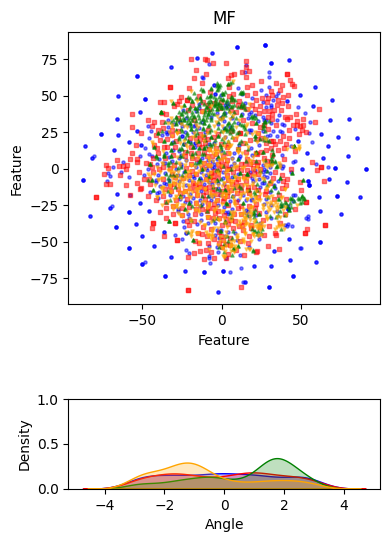

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
from sklearn.manifold import TSNE
import seaborn as sns
import random

np.random.seed(42)
random.seed(42)
torch.manual_seed(42)

# Load data
train_data = pd.read_csv('./dataset/douban-book/train.txt', delim_whitespace=True, header=None, names=['user_id', 'item_id', 'interaction'])
test_data = pd.read_csv('./dataset/douban-book/test.txt', delim_whitespace=True, header=None, names=['user_id', 'item_id', 'interaction'])
user_emb = torch.load('./embedding/base/MF_douban-book/best_user_emb.pt', map_location=torch.device('cpu'))
item_emb = torch.load('./embedding/base/MF_douban-book/best_item_emb.pt', map_location=torch.device('cpu'))

# Calculate popularity
combined_data = pd.concat([train_data, test_data])
user_popularity = combined_data.groupby('user_id')['interaction'].sum().reset_index()
item_popularity = combined_data.groupby('item_id')['interaction'].sum().reset_index()

# Define thresholds for hot and cold sampling
user_hot_threshold = user_popularity['interaction'].quantile(0.95)
user_cold_threshold = user_popularity['interaction'].quantile(0.80)
item_hot_threshold = item_popularity['interaction'].quantile(0.95)
item_cold_threshold = item_popularity['interaction'].quantile(0.80)

# Sample hot and cold users/items
hot_users = user_popularity[user_popularity['interaction'] > user_hot_threshold].sample(500, replace=True)
cold_users = user_popularity[user_popularity['interaction'] <= user_cold_threshold].sample(500, replace=True)
hot_items = item_popularity[item_popularity['interaction'] > item_hot_threshold].sample(500, replace=True)
cold_items = item_popularity[item_popularity['interaction'] <= item_cold_threshold].sample(500, replace=True)

# Ensure that user and item ids are within the valid index range
valid_user_ids = hot_users['user_id'].apply(lambda x: x < user_emb.shape[0])
valid_item_ids = hot_items['item_id'].apply(lambda x: x < item_emb.shape[0])

hot_users = hot_users[valid_user_ids]
hot_items = hot_items[valid_item_ids]

valid_user_ids = cold_users['user_id'].apply(lambda x: x < user_emb.shape[0])
valid_item_ids = cold_items['item_id'].apply(lambda x: x < item_emb.shape[0])

cold_users = cold_users[valid_user_ids]
cold_items = cold_items[valid_item_ids]

# Now extract embeddings
hot_user_emb = user_emb[hot_users['user_id'].values]
cold_user_emb = user_emb[cold_users['user_id'].values]
hot_item_emb = item_emb[hot_items['item_id'].values]
cold_item_emb = item_emb[cold_items['item_id'].values]



# Combine and map to 2D using t-SNE
combined_user_emb = torch.cat([hot_user_emb, cold_user_emb])
combined_item_emb = torch.cat([hot_item_emb, cold_item_emb])
tsne = TSNE(n_components=2, random_state=42)
# user_emb_2d = tsne.fit_transform(combined_user_emb)
user_emb_2d = tsne.fit_transform(combined_user_emb.detach().numpy())
item_emb_2d = tsne.fit_transform(combined_item_emb.detach().numpy())

angles_hot_users = np.arctan2(user_emb_2d[:500, 1], user_emb_2d[:500, 0])
angles_cold_users = np.arctan2(user_emb_2d[500:, 1], user_emb_2d[500:, 0])
angles_hot_items = np.arctan2(item_emb_2d[:500, 1], item_emb_2d[:500, 0])
angles_cold_items = np.arctan2(item_emb_2d[500:, 1], item_emb_2d[500:, 0])

# Create a new figure for both the scatter and KDE plots
plt.figure(figsize=(4, 6))

plt.subplot(2, 1, 1)
plt.scatter(user_emb_2d[:500, 0], user_emb_2d[:500, 1], s=5, alpha=0.5, label='Hot Users', color='blue', marker='o')
plt.scatter(user_emb_2d[500:, 0], user_emb_2d[500:, 1], s=5, alpha=0.5, label='Cold Users', color='red', marker='s')
plt.scatter(item_emb_2d[:500, 0], item_emb_2d[:500, 1], s=5, alpha=0.5, label='Hot Items', color='green', marker='^')
plt.scatter(item_emb_2d[500:, 0], item_emb_2d[500:, 1], s=5, alpha=0.5, label='Cold Items', color='orange', marker='v')

plt.title("MF")
plt.xlabel("Feature")
plt.ylabel("Feature")
# plt.legend()

# Plot KDE for angles
plt.subplot(2, 1, 2, aspect=3)
sns.kdeplot(angles_hot_users, fill=True, color='blue', label='Hot Users')  # dark gray
sns.kdeplot(angles_cold_users, fill=True, color='red', label='Cold Users')  # medium-dark gray
sns.kdeplot(angles_hot_items, fill=True, color='green', label='Hot Items')  # medium-light gray
sns.kdeplot(angles_cold_items, fill=True, color='orange', label='Cold Items')  # light gray

# Labeling the plot
# plt.title("KDE of atan2(y, x) for Each Group")
plt.xlabel("Angle")
plt.ylabel("Density")
plt.ylim(0, 1)
# plt.legend()

plt.tight_layout()
plt.savefig('/Users/mean/Downloads/ThinGCN/embedding/base/MF_douban-book/MF.png')
plt.show()

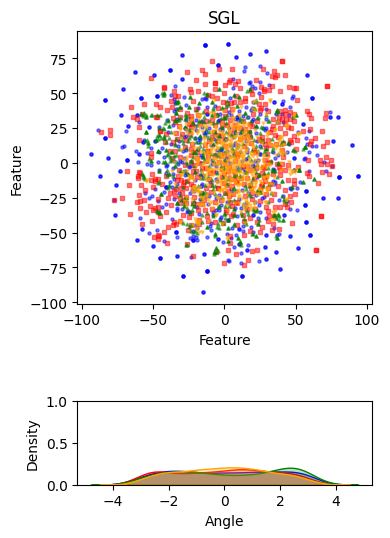

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
from sklearn.manifold import TSNE
import seaborn as sns
import random

np.random.seed(42)
random.seed(42)
torch.manual_seed(42)

# Load data
train_data = pd.read_csv('./dataset/douban-book/train.txt', delim_whitespace=True, header=None, names=['user_id', 'item_id', 'interaction'])
test_data = pd.read_csv('./dataset/douban-book/test.txt', delim_whitespace=True, header=None, names=['user_id', 'item_id', 'interaction'])
user_emb = torch.load('./embedding/base/SGL_douban-book/best_user_emb.pt', map_location=torch.device('cpu'))
item_emb = torch.load('./embedding/base/SGL_douban-book/best_item_emb.pt', map_location=torch.device('cpu'))

# Calculate popularity
combined_data = pd.concat([train_data, test_data])
user_popularity = combined_data.groupby('user_id')['interaction'].sum().reset_index()
item_popularity = combined_data.groupby('item_id')['interaction'].sum().reset_index()

# Define thresholds for hot and cold sampling
user_hot_threshold = user_popularity['interaction'].quantile(0.95)
user_cold_threshold = user_popularity['interaction'].quantile(0.80)
item_hot_threshold = item_popularity['interaction'].quantile(0.95)
item_cold_threshold = item_popularity['interaction'].quantile(0.80)

# Sample hot and cold users/items
hot_users = user_popularity[user_popularity['interaction'] > user_hot_threshold].sample(500, replace=True)
cold_users = user_popularity[user_popularity['interaction'] <= user_cold_threshold].sample(500, replace=True)
hot_items = item_popularity[item_popularity['interaction'] > item_hot_threshold].sample(500, replace=True)
cold_items = item_popularity[item_popularity['interaction'] <= item_cold_threshold].sample(500, replace=True)

# Ensure that user and item ids are within the valid index range
valid_user_ids = hot_users['user_id'].apply(lambda x: x < user_emb.shape[0])
valid_item_ids = hot_items['item_id'].apply(lambda x: x < item_emb.shape[0])

hot_users = hot_users[valid_user_ids]
hot_items = hot_items[valid_item_ids]

valid_user_ids = cold_users['user_id'].apply(lambda x: x < user_emb.shape[0])
valid_item_ids = cold_items['item_id'].apply(lambda x: x < item_emb.shape[0])

cold_users = cold_users[valid_user_ids]
cold_items = cold_items[valid_item_ids]

# Now extract embeddings
hot_user_emb = user_emb[hot_users['user_id'].values]
cold_user_emb = user_emb[cold_users['user_id'].values]
hot_item_emb = item_emb[hot_items['item_id'].values]
cold_item_emb = item_emb[cold_items['item_id'].values]



# Combine and map to 2D using t-SNE
combined_user_emb = torch.cat([hot_user_emb, cold_user_emb])
combined_item_emb = torch.cat([hot_item_emb, cold_item_emb])
tsne = TSNE(n_components=2, random_state=42)
# user_emb_2d = tsne.fit_transform(combined_user_emb)
user_emb_2d = tsne.fit_transform(combined_user_emb.detach().numpy())
item_emb_2d = tsne.fit_transform(combined_item_emb.detach().numpy())

angles_hot_users = np.arctan2(user_emb_2d[:500, 1], user_emb_2d[:500, 0])
angles_cold_users = np.arctan2(user_emb_2d[500:, 1], user_emb_2d[500:, 0])
angles_hot_items = np.arctan2(item_emb_2d[:500, 1], item_emb_2d[:500, 0])
angles_cold_items = np.arctan2(item_emb_2d[500:, 1], item_emb_2d[500:, 0])

# Create a new figure for both the scatter and KDE plots
plt.figure(figsize=(4, 6))

plt.subplot(2, 1, 1)
plt.scatter(user_emb_2d[:500, 0], user_emb_2d[:500, 1], s=5, alpha=0.5, label='Hot Users', color='blue', marker='o')
plt.scatter(user_emb_2d[500:, 0], user_emb_2d[500:, 1], s=5, alpha=0.5, label='Cold Users', color='red', marker='s')
plt.scatter(item_emb_2d[:500, 0], item_emb_2d[:500, 1], s=5, alpha=0.5, label='Hot Items', color='green', marker='^')
plt.scatter(item_emb_2d[500:, 0], item_emb_2d[500:, 1], s=5, alpha=0.5, label='Cold Items', color='orange', marker='v')

plt.title("SGL")
plt.xlabel("Feature")
plt.ylabel("Feature")
# plt.legend()

# Plot KDE for angles
plt.subplot(2, 1, 2, aspect=3)
sns.kdeplot(angles_hot_users, fill=True, color='blue', label='Hot Users')  # dark gray
sns.kdeplot(angles_cold_users, fill=True, color='red', label='Cold Users')  # medium-dark gray
sns.kdeplot(angles_hot_items, fill=True, color='green', label='Hot Items')  # medium-light gray
sns.kdeplot(angles_cold_items, fill=True, color='orange', label='Cold Items')  # light gray

# Labeling the plot
# plt.title("KDE of atan2(y, x) for Each Group")
plt.xlabel("Angle")
plt.ylabel("Density")
plt.ylim(0, 1)
# plt.legend()

plt.tight_layout()
plt.savefig('/Users/mean/Downloads/ThinGCN/embedding/base/SGL_douban-book/SGL.png')
plt.show()

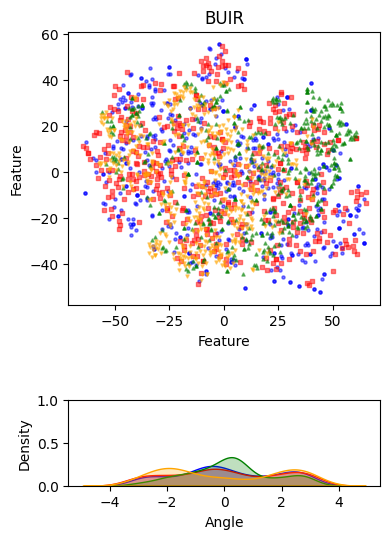

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
from sklearn.manifold import TSNE
import seaborn as sns
import random

np.random.seed(42)
random.seed(42)
torch.manual_seed(42)

# Load data
train_data = pd.read_csv('./dataset/douban-book/train.txt', delim_whitespace=True, header=None, names=['user_id', 'item_id', 'interaction'])
test_data = pd.read_csv('./dataset/douban-book/test.txt', delim_whitespace=True, header=None, names=['user_id', 'item_id', 'interaction'])
# user_emb = torch.load('./embedding/base/SelfCF_douban-book/best_user_emb.pt', map_location=torch.device('cpu'))
# item_emb = torch.load('./embedding/base/SelfCF_douban-book/best_item_emb.pt', map_location=torch.device('cpu'))

best_p_u = torch.load('./embedding/base/BUIR_douban-book/best_p_u.pt', map_location=torch.device('cpu'))
best_u = torch.load('./embedding/base/BUIR_douban-book/best_u.pt', map_location=torch.device('cpu'))
best_p_i = torch.load('./embedding/base/BUIR_douban-book/best_p_i.pt', map_location=torch.device('cpu'))
best_i = torch.load('./embedding/base/BUIR_douban-book/best_i.pt', map_location=torch.device('cpu'))

# Creating combined embeddings
user_emb = best_p_u + best_u
item_emb = best_p_i + best_i

# Calculate popularity
combined_data = pd.concat([train_data, test_data])
user_popularity = combined_data.groupby('user_id')['interaction'].sum().reset_index()
item_popularity = combined_data.groupby('item_id')['interaction'].sum().reset_index()

# Define thresholds for hot and cold sampling
user_hot_threshold = user_popularity['interaction'].quantile(0.95)
user_cold_threshold = user_popularity['interaction'].quantile(0.80)
item_hot_threshold = item_popularity['interaction'].quantile(0.95)
item_cold_threshold = item_popularity['interaction'].quantile(0.80)

# Sample hot and cold users/items
hot_users = user_popularity[user_popularity['interaction'] > user_hot_threshold].sample(500, replace=True)
cold_users = user_popularity[user_popularity['interaction'] <= user_cold_threshold].sample(500, replace=True)
hot_items = item_popularity[item_popularity['interaction'] > item_hot_threshold].sample(500, replace=True)
cold_items = item_popularity[item_popularity['interaction'] <= item_cold_threshold].sample(500, replace=True)

# Ensure that user and item ids are within the valid index range
valid_user_ids = hot_users['user_id'].apply(lambda x: x < user_emb.shape[0])
valid_item_ids = hot_items['item_id'].apply(lambda x: x < item_emb.shape[0])

hot_users = hot_users[valid_user_ids]
hot_items = hot_items[valid_item_ids]

valid_user_ids = cold_users['user_id'].apply(lambda x: x < user_emb.shape[0])
valid_item_ids = cold_items['item_id'].apply(lambda x: x < item_emb.shape[0])

cold_users = cold_users[valid_user_ids]
cold_items = cold_items[valid_item_ids]

# Now extract embeddings
hot_user_emb = user_emb[hot_users['user_id'].values]
cold_user_emb = user_emb[cold_users['user_id'].values]
hot_item_emb = item_emb[hot_items['item_id'].values]
cold_item_emb = item_emb[cold_items['item_id'].values]



# Combine and map to 2D using t-SNE
combined_user_emb = torch.cat([hot_user_emb, cold_user_emb])
combined_item_emb = torch.cat([hot_item_emb, cold_item_emb])
tsne = TSNE(n_components=2, random_state=42)
# user_emb_2d = tsne.fit_transform(combined_user_emb)
user_emb_2d = tsne.fit_transform(combined_user_emb.detach().numpy())
item_emb_2d = tsne.fit_transform(combined_item_emb.detach().numpy())

angles_hot_users = np.arctan2(user_emb_2d[:500, 1], user_emb_2d[:500, 0])
angles_cold_users = np.arctan2(user_emb_2d[500:, 1], user_emb_2d[500:, 0])
angles_hot_items = np.arctan2(item_emb_2d[:500, 1], item_emb_2d[:500, 0])
angles_cold_items = np.arctan2(item_emb_2d[500:, 1], item_emb_2d[500:, 0])

# Create a new figure for both the scatter and KDE plots
plt.figure(figsize=(4, 6))

plt.subplot(2, 1, 1)
plt.scatter(user_emb_2d[:500, 0], user_emb_2d[:500, 1], s=5, alpha=0.5, label='Hot Users', color='blue', marker='o')
plt.scatter(user_emb_2d[500:, 0], user_emb_2d[500:, 1], s=5, alpha=0.5, label='Cold Users', color='red', marker='s')
plt.scatter(item_emb_2d[:500, 0], item_emb_2d[:500, 1], s=5, alpha=0.5, label='Hot Items', color='green', marker='^')
plt.scatter(item_emb_2d[500:, 0], item_emb_2d[500:, 1], s=5, alpha=0.5, label='Cold Items', color='orange', marker='v')

plt.title("BUIR")
plt.xlabel("Feature")
plt.ylabel("Feature")
# plt.legend()

# Plot KDE for angles
plt.subplot(2, 1, 2, aspect=3)
sns.kdeplot(angles_hot_users, fill=True, color='blue', label='Hot Users')  # dark gray
sns.kdeplot(angles_cold_users, fill=True, color='red', label='Cold Users')  # medium-dark gray
sns.kdeplot(angles_hot_items, fill=True, color='green', label='Hot Items')  # medium-light gray
sns.kdeplot(angles_cold_items, fill=True, color='orange', label='Cold Items')  # light gray

# Labeling the plot
# plt.title("KDE of atan2(y, x) for Each Group")
plt.xlabel("Angle")
plt.ylabel("Density")
plt.ylim(0, 1)
# plt.legend()

plt.tight_layout()
plt.savefig('/Users/mean/Downloads/ThinGCN/embedding/base/BUIR_douban-book/BUIR.png')
plt.show()

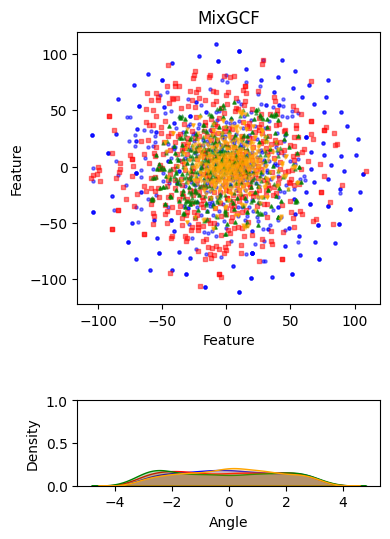

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
from sklearn.manifold import TSNE
import seaborn as sns
import random

np.random.seed(42)
random.seed(42)
torch.manual_seed(42)

# Load data
train_data = pd.read_csv('./dataset/douban-book/train.txt', delim_whitespace=True, header=None, names=['user_id', 'item_id', 'interaction'])
test_data = pd.read_csv('./dataset/douban-book/test.txt', delim_whitespace=True, header=None, names=['user_id', 'item_id', 'interaction'])
user_emb = torch.load('./embedding/base/MixGCF_douban-book/best_user_emb.pt', map_location=torch.device('cpu'))
item_emb = torch.load('./embedding/base/MixGCF_douban-book/best_item_emb.pt', map_location=torch.device('cpu'))

# Calculate popularity
combined_data = pd.concat([train_data, test_data])
user_popularity = combined_data.groupby('user_id')['interaction'].sum().reset_index()
item_popularity = combined_data.groupby('item_id')['interaction'].sum().reset_index()

# Define thresholds for hot and cold sampling
user_hot_threshold = user_popularity['interaction'].quantile(0.95)
user_cold_threshold = user_popularity['interaction'].quantile(0.80)
item_hot_threshold = item_popularity['interaction'].quantile(0.95)
item_cold_threshold = item_popularity['interaction'].quantile(0.80)

# Sample hot and cold users/items
hot_users = user_popularity[user_popularity['interaction'] > user_hot_threshold].sample(500, replace=True)
cold_users = user_popularity[user_popularity['interaction'] <= user_cold_threshold].sample(500, replace=True)
hot_items = item_popularity[item_popularity['interaction'] > item_hot_threshold].sample(500, replace=True)
cold_items = item_popularity[item_popularity['interaction'] <= item_cold_threshold].sample(500, replace=True)

# Ensure that user and item ids are within the valid index range
valid_user_ids = hot_users['user_id'].apply(lambda x: x < user_emb.shape[0])
valid_item_ids = hot_items['item_id'].apply(lambda x: x < item_emb.shape[0])

hot_users = hot_users[valid_user_ids]
hot_items = hot_items[valid_item_ids]

valid_user_ids = cold_users['user_id'].apply(lambda x: x < user_emb.shape[0])
valid_item_ids = cold_items['item_id'].apply(lambda x: x < item_emb.shape[0])

cold_users = cold_users[valid_user_ids]
cold_items = cold_items[valid_item_ids]

# Now extract embeddings
hot_user_emb = user_emb[hot_users['user_id'].values]
cold_user_emb = user_emb[cold_users['user_id'].values]
hot_item_emb = item_emb[hot_items['item_id'].values]
cold_item_emb = item_emb[cold_items['item_id'].values]



# Combine and map to 2D using t-SNE
combined_user_emb = torch.cat([hot_user_emb, cold_user_emb])
combined_item_emb = torch.cat([hot_item_emb, cold_item_emb])
tsne = TSNE(n_components=2, random_state=42)
# user_emb_2d = tsne.fit_transform(combined_user_emb)
user_emb_2d = tsne.fit_transform(combined_user_emb.detach().numpy())
item_emb_2d = tsne.fit_transform(combined_item_emb.detach().numpy())

angles_hot_users = np.arctan2(user_emb_2d[:500, 1], user_emb_2d[:500, 0])
angles_cold_users = np.arctan2(user_emb_2d[500:, 1], user_emb_2d[500:, 0])
angles_hot_items = np.arctan2(item_emb_2d[:500, 1], item_emb_2d[:500, 0])
angles_cold_items = np.arctan2(item_emb_2d[500:, 1], item_emb_2d[500:, 0])

# Create a new figure for both the scatter and KDE plots
plt.figure(figsize=(4, 6))

plt.subplot(2, 1, 1)
plt.scatter(user_emb_2d[:500, 0], user_emb_2d[:500, 1], s=5, alpha=0.5, label='Hot Users', color='blue', marker='o')
plt.scatter(user_emb_2d[500:, 0], user_emb_2d[500:, 1], s=5, alpha=0.5, label='Cold Users', color='red', marker='s')
plt.scatter(item_emb_2d[:500, 0], item_emb_2d[:500, 1], s=5, alpha=0.5, label='Hot Items', color='green', marker='^')
plt.scatter(item_emb_2d[500:, 0], item_emb_2d[500:, 1], s=5, alpha=0.5, label='Cold Items', color='orange', marker='v')

plt.title("MixGCF")
plt.xlabel("Feature")
plt.ylabel("Feature")
# plt.legend()

# Plot KDE for angles
plt.subplot(2, 1, 2, aspect=3)
sns.kdeplot(angles_hot_users, fill=True, color='blue', label='Hot Users')  # dark gray
sns.kdeplot(angles_cold_users, fill=True, color='red', label='Cold Users')  # medium-dark gray
sns.kdeplot(angles_hot_items, fill=True, color='green', label='Hot Items')  # medium-light gray
sns.kdeplot(angles_cold_items, fill=True, color='orange', label='Cold Items')  # light gray

# Labeling the plot
# plt.title("KDE of atan2(y, x) for Each Group")
plt.xlabel("Angle")
plt.ylabel("Density")
plt.ylim(0, 1)
# plt.legend()

plt.tight_layout()
plt.savefig('/Users/mean/Downloads/ThinGCN/embedding/base/MixGCF_douban-book/MixGCF.png')
plt.show()

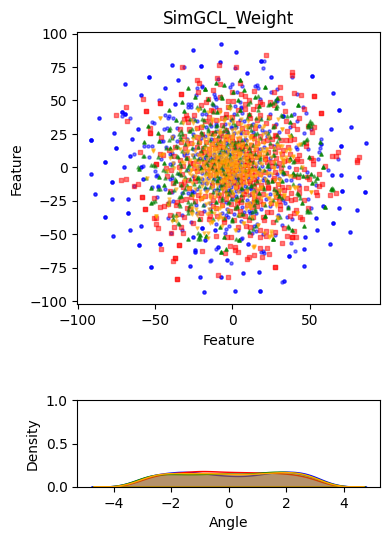

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
from sklearn.manifold import TSNE
import seaborn as sns
import random

np.random.seed(42)
random.seed(42)
torch.manual_seed(42)

# Load data
train_data = pd.read_csv('./dataset/douban-book/train.txt', delim_whitespace=True, header=None, names=['user_id', 'item_id', 'interaction'])
test_data = pd.read_csv('./dataset/douban-book/test.txt', delim_whitespace=True, header=None, names=['user_id', 'item_id', 'interaction'])
user_emb = torch.load('./embedding/Weight/SimGCL_Weight/douban-book/best_user_emb.pt', map_location=torch.device('cpu'))
item_emb = torch.load('./embedding/Weight/SimGCL_Weight/douban-book/best_item_emb.pt', map_location=torch.device('cpu'))

# Calculate popularity
combined_data = pd.concat([train_data, test_data])
user_popularity = combined_data.groupby('user_id')['interaction'].sum().reset_index()
item_popularity = combined_data.groupby('item_id')['interaction'].sum().reset_index()

# Define thresholds for hot and cold sampling
user_hot_threshold = user_popularity['interaction'].quantile(0.95)
user_cold_threshold = user_popularity['interaction'].quantile(0.80)
item_hot_threshold = item_popularity['interaction'].quantile(0.95)
item_cold_threshold = item_popularity['interaction'].quantile(0.80)

# Sample hot and cold users/items
hot_users = user_popularity[user_popularity['interaction'] > user_hot_threshold].sample(500, replace=True)
cold_users = user_popularity[user_popularity['interaction'] <= user_cold_threshold].sample(500, replace=True)
hot_items = item_popularity[item_popularity['interaction'] > item_hot_threshold].sample(500, replace=True)
cold_items = item_popularity[item_popularity['interaction'] <= item_cold_threshold].sample(500, replace=True)

# Ensure that user and item ids are within the valid index range
valid_user_ids = hot_users['user_id'].apply(lambda x: x < user_emb.shape[0])
valid_item_ids = hot_items['item_id'].apply(lambda x: x < item_emb.shape[0])

hot_users = hot_users[valid_user_ids]
hot_items = hot_items[valid_item_ids]

valid_user_ids = cold_users['user_id'].apply(lambda x: x < user_emb.shape[0])
valid_item_ids = cold_items['item_id'].apply(lambda x: x < item_emb.shape[0])

cold_users = cold_users[valid_user_ids]
cold_items = cold_items[valid_item_ids]

# Now extract embeddings
hot_user_emb = user_emb[hot_users['user_id'].values]
cold_user_emb = user_emb[cold_users['user_id'].values]
hot_item_emb = item_emb[hot_items['item_id'].values]
cold_item_emb = item_emb[cold_items['item_id'].values]



# Combine and map to 2D using t-SNE
combined_user_emb = torch.cat([hot_user_emb, cold_user_emb])
combined_item_emb = torch.cat([hot_item_emb, cold_item_emb])
tsne = TSNE(n_components=2, random_state=42)
# user_emb_2d = tsne.fit_transform(combined_user_emb)
user_emb_2d = tsne.fit_transform(combined_user_emb.detach().numpy())
item_emb_2d = tsne.fit_transform(combined_item_emb.detach().numpy())

angles_hot_users = np.arctan2(user_emb_2d[:500, 1], user_emb_2d[:500, 0])
angles_cold_users = np.arctan2(user_emb_2d[500:, 1], user_emb_2d[500:, 0])
angles_hot_items = np.arctan2(item_emb_2d[:500, 1], item_emb_2d[:500, 0])
angles_cold_items = np.arctan2(item_emb_2d[500:, 1], item_emb_2d[500:, 0])

# Create a new figure for both the scatter and KDE plots
plt.figure(figsize=(4, 6))

plt.subplot(2, 1, 1)
plt.scatter(user_emb_2d[:500, 0], user_emb_2d[:500, 1], s=5, alpha=0.5, label='Hot Users', color='blue', marker='o')
plt.scatter(user_emb_2d[500:, 0], user_emb_2d[500:, 1], s=5, alpha=0.5, label='Cold Users', color='red', marker='s')
plt.scatter(item_emb_2d[:500, 0], item_emb_2d[:500, 1], s=5, alpha=0.5, label='Hot Items', color='green', marker='^')
plt.scatter(item_emb_2d[500:, 0], item_emb_2d[500:, 1], s=5, alpha=0.5, label='Cold Items', color='orange', marker='v')

plt.title("SimGCL_Weight")
plt.xlabel("Feature")
plt.ylabel("Feature")
# plt.legend()

# Plot KDE for angles
plt.subplot(2, 1, 2, aspect=3)
sns.kdeplot(angles_hot_users, fill=True, color='blue', label='Hot Users')  # dark gray
sns.kdeplot(angles_cold_users, fill=True, color='red', label='Cold Users')  # medium-dark gray
sns.kdeplot(angles_hot_items, fill=True, color='green', label='Hot Items')  # medium-light gray
sns.kdeplot(angles_cold_items, fill=True, color='orange', label='Cold Items')  # light gray

# Labeling the plot
# plt.title("KDE of atan2(y, x) for Each Group")
plt.xlabel("Angle")
plt.ylabel("Density")
plt.ylim(0, 1)
# plt.legend()

plt.tight_layout()
plt.savefig('/Users/mean/Downloads/ThinGCN/embedding/Weight/SimGCL_Weight/douban-book/SimGCL_Weight.png')
plt.show()

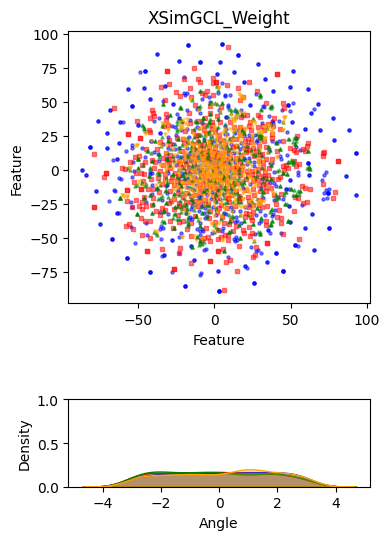

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
from sklearn.manifold import TSNE
import seaborn as sns
import random

np.random.seed(42)
random.seed(42)
torch.manual_seed(42)

# Load data
train_data = pd.read_csv('./dataset/douban-book/train.txt', delim_whitespace=True, header=None, names=['user_id', 'item_id', 'interaction'])
test_data = pd.read_csv('./dataset/douban-book/test.txt', delim_whitespace=True, header=None, names=['user_id', 'item_id', 'interaction'])
user_emb = torch.load('./embedding/Weight/XSimGCL_Weight/douban-book/best_user_emb.pt', map_location=torch.device('cpu'))
item_emb = torch.load('./embedding/Weight/XSimGCL_Weight/douban-book/best_item_emb.pt', map_location=torch.device('cpu'))

# Calculate popularity
combined_data = pd.concat([train_data, test_data])
user_popularity = combined_data.groupby('user_id')['interaction'].sum().reset_index()
item_popularity = combined_data.groupby('item_id')['interaction'].sum().reset_index()

# Define thresholds for hot and cold sampling
user_hot_threshold = user_popularity['interaction'].quantile(0.95)
user_cold_threshold = user_popularity['interaction'].quantile(0.80)
item_hot_threshold = item_popularity['interaction'].quantile(0.95)
item_cold_threshold = item_popularity['interaction'].quantile(0.80)

# Sample hot and cold users/items
hot_users = user_popularity[user_popularity['interaction'] > user_hot_threshold].sample(500, replace=True)
cold_users = user_popularity[user_popularity['interaction'] <= user_cold_threshold].sample(500, replace=True)
hot_items = item_popularity[item_popularity['interaction'] > item_hot_threshold].sample(500, replace=True)
cold_items = item_popularity[item_popularity['interaction'] <= item_cold_threshold].sample(500, replace=True)

# Ensure that user and item ids are within the valid index range
valid_user_ids = hot_users['user_id'].apply(lambda x: x < user_emb.shape[0])
valid_item_ids = hot_items['item_id'].apply(lambda x: x < item_emb.shape[0])

hot_users = hot_users[valid_user_ids]
hot_items = hot_items[valid_item_ids]

valid_user_ids = cold_users['user_id'].apply(lambda x: x < user_emb.shape[0])
valid_item_ids = cold_items['item_id'].apply(lambda x: x < item_emb.shape[0])

cold_users = cold_users[valid_user_ids]
cold_items = cold_items[valid_item_ids]

# Now extract embeddings
hot_user_emb = user_emb[hot_users['user_id'].values]
cold_user_emb = user_emb[cold_users['user_id'].values]
hot_item_emb = item_emb[hot_items['item_id'].values]
cold_item_emb = item_emb[cold_items['item_id'].values]



# Combine and map to 2D using t-SNE
combined_user_emb = torch.cat([hot_user_emb, cold_user_emb])
combined_item_emb = torch.cat([hot_item_emb, cold_item_emb])
tsne = TSNE(n_components=2, random_state=42)
# user_emb_2d = tsne.fit_transform(combined_user_emb)
user_emb_2d = tsne.fit_transform(combined_user_emb.detach().numpy())
item_emb_2d = tsne.fit_transform(combined_item_emb.detach().numpy())

angles_hot_users = np.arctan2(user_emb_2d[:500, 1], user_emb_2d[:500, 0])
angles_cold_users = np.arctan2(user_emb_2d[500:, 1], user_emb_2d[500:, 0])
angles_hot_items = np.arctan2(item_emb_2d[:500, 1], item_emb_2d[:500, 0])
angles_cold_items = np.arctan2(item_emb_2d[500:, 1], item_emb_2d[500:, 0])

# Create a new figure for both the scatter and KDE plots
plt.figure(figsize=(4, 6))

plt.subplot(2, 1, 1)
plt.scatter(user_emb_2d[:500, 0], user_emb_2d[:500, 1], s=5, alpha=0.5, label='Hot Users', color='blue', marker='o')
plt.scatter(user_emb_2d[500:, 0], user_emb_2d[500:, 1], s=5, alpha=0.5, label='Cold Users', color='red', marker='s')
plt.scatter(item_emb_2d[:500, 0], item_emb_2d[:500, 1], s=5, alpha=0.5, label='Hot Items', color='green', marker='^')
plt.scatter(item_emb_2d[500:, 0], item_emb_2d[500:, 1], s=5, alpha=0.5, label='Cold Items', color='orange', marker='v')

plt.title("XSimGCL_Weight")
plt.xlabel("Feature")
plt.ylabel("Feature")
# plt.legend()

# Plot KDE for angles
plt.subplot(2, 1, 2, aspect=3)
sns.kdeplot(angles_hot_users, fill=True, color='blue', label='Hot Users')  # dark gray
sns.kdeplot(angles_cold_users, fill=True, color='red', label='Cold Users')  # medium-dark gray
sns.kdeplot(angles_hot_items, fill=True, color='green', label='Hot Items')  # medium-light gray
sns.kdeplot(angles_cold_items, fill=True, color='orange', label='Cold Items')  # light gray

# Labeling the plot
# plt.title("KDE of atan2(y, x) for Each Group")
plt.xlabel("Angle")
plt.ylabel("Density")
plt.ylim(0, 1)
# plt.legend()

plt.tight_layout()
plt.savefig('/Users/mean/Downloads/ThinGCN/embedding/Weight/XSimGCL_Weight/douban-book/XSimGCL_Weight.png')
plt.show()

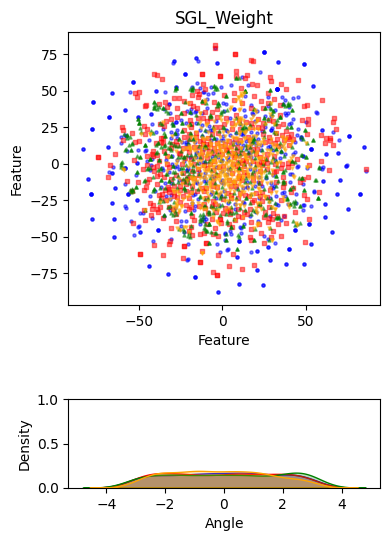

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
from sklearn.manifold import TSNE
import seaborn as sns
import random

np.random.seed(42)
random.seed(42)
torch.manual_seed(42)

# Load data
train_data = pd.read_csv('./dataset/douban-book/train.txt', delim_whitespace=True, header=None, names=['user_id', 'item_id', 'interaction'])
test_data = pd.read_csv('./dataset/douban-book/test.txt', delim_whitespace=True, header=None, names=['user_id', 'item_id', 'interaction'])
user_emb = torch.load('./embedding/Weight/SGL_Weight/douban-book/best_user_emb.pt', map_location=torch.device('cpu'))
item_emb = torch.load('./embedding/Weight/SGL_Weight/douban-book/best_item_emb.pt', map_location=torch.device('cpu'))

# Calculate popularity
combined_data = pd.concat([train_data, test_data])
user_popularity = combined_data.groupby('user_id')['interaction'].sum().reset_index()
item_popularity = combined_data.groupby('item_id')['interaction'].sum().reset_index()

# Define thresholds for hot and cold sampling
user_hot_threshold = user_popularity['interaction'].quantile(0.95)
user_cold_threshold = user_popularity['interaction'].quantile(0.80)
item_hot_threshold = item_popularity['interaction'].quantile(0.95)
item_cold_threshold = item_popularity['interaction'].quantile(0.80)

# Sample hot and cold users/items
hot_users = user_popularity[user_popularity['interaction'] > user_hot_threshold].sample(500, replace=True)
cold_users = user_popularity[user_popularity['interaction'] <= user_cold_threshold].sample(500, replace=True)
hot_items = item_popularity[item_popularity['interaction'] > item_hot_threshold].sample(500, replace=True)
cold_items = item_popularity[item_popularity['interaction'] <= item_cold_threshold].sample(500, replace=True)

# Ensure that user and item ids are within the valid index range
valid_user_ids = hot_users['user_id'].apply(lambda x: x < user_emb.shape[0])
valid_item_ids = hot_items['item_id'].apply(lambda x: x < item_emb.shape[0])

hot_users = hot_users[valid_user_ids]
hot_items = hot_items[valid_item_ids]

valid_user_ids = cold_users['user_id'].apply(lambda x: x < user_emb.shape[0])
valid_item_ids = cold_items['item_id'].apply(lambda x: x < item_emb.shape[0])

cold_users = cold_users[valid_user_ids]
cold_items = cold_items[valid_item_ids]

# Now extract embeddings
hot_user_emb = user_emb[hot_users['user_id'].values]
cold_user_emb = user_emb[cold_users['user_id'].values]
hot_item_emb = item_emb[hot_items['item_id'].values]
cold_item_emb = item_emb[cold_items['item_id'].values]



# Combine and map to 2D using t-SNE
combined_user_emb = torch.cat([hot_user_emb, cold_user_emb])
combined_item_emb = torch.cat([hot_item_emb, cold_item_emb])
tsne = TSNE(n_components=2, random_state=42)
# user_emb_2d = tsne.fit_transform(combined_user_emb)
user_emb_2d = tsne.fit_transform(combined_user_emb.detach().numpy())
item_emb_2d = tsne.fit_transform(combined_item_emb.detach().numpy())

angles_hot_users = np.arctan2(user_emb_2d[:500, 1], user_emb_2d[:500, 0])
angles_cold_users = np.arctan2(user_emb_2d[500:, 1], user_emb_2d[500:, 0])
angles_hot_items = np.arctan2(item_emb_2d[:500, 1], item_emb_2d[:500, 0])
angles_cold_items = np.arctan2(item_emb_2d[500:, 1], item_emb_2d[500:, 0])

# Create a new figure for both the scatter and KDE plots
plt.figure(figsize=(4, 6))

plt.subplot(2, 1, 1)
plt.scatter(user_emb_2d[:500, 0], user_emb_2d[:500, 1], s=5, alpha=0.5, label='Hot Users', color='blue', marker='o')
plt.scatter(user_emb_2d[500:, 0], user_emb_2d[500:, 1], s=5, alpha=0.5, label='Cold Users', color='red', marker='s')
plt.scatter(item_emb_2d[:500, 0], item_emb_2d[:500, 1], s=5, alpha=0.5, label='Hot Items', color='green', marker='^')
plt.scatter(item_emb_2d[500:, 0], item_emb_2d[500:, 1], s=5, alpha=0.5, label='Cold Items', color='orange', marker='v')

plt.title("SGL_Weight")
plt.xlabel("Feature")
plt.ylabel("Feature")
# plt.legend()

# Plot KDE for angles
plt.subplot(2, 1, 2, aspect=3)
sns.kdeplot(angles_hot_users, fill=True, color='blue', label='Hot Users')  # dark gray
sns.kdeplot(angles_cold_users, fill=True, color='red', label='Cold Users')  # medium-dark gray
sns.kdeplot(angles_hot_items, fill=True, color='green', label='Hot Items')  # medium-light gray
sns.kdeplot(angles_cold_items, fill=True, color='orange', label='Cold Items')  # light gray

# Labeling the plot
# plt.title("KDE of atan2(y, x) for Each Group")
plt.xlabel("Angle")
plt.ylabel("Density")
plt.ylim(0, 1)
# plt.legend()

plt.tight_layout()
plt.savefig('/Users/mean/Downloads/ThinGCN/embedding/Weight/SGL_Weight/douban-book/SGL_Weight.png')
plt.show()

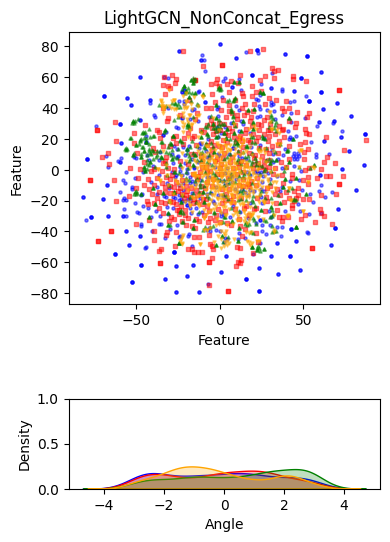

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
from sklearn.manifold import TSNE
import seaborn as sns
import random

np.random.seed(42)
random.seed(42)
torch.manual_seed(42)

# Load data
train_data = pd.read_csv('./dataset/douban-book/train.txt', delim_whitespace=True, header=None, names=['user_id', 'item_id', 'interaction'])
test_data = pd.read_csv('./dataset/douban-book/test.txt', delim_whitespace=True, header=None, names=['user_id', 'item_id', 'interaction'])
user_emb = torch.load('./embedding/NonConcat_Egress/LightGCN_NonConcat_Egress/douban-book/best_user_emb.pt', map_location=torch.device('cpu'))
item_emb = torch.load('./embedding/NonConcat_Egress/LightGCN_NonConcat_Egress/douban-book/best_item_emb.pt', map_location=torch.device('cpu'))

# Calculate popularity
combined_data = pd.concat([train_data, test_data])
user_popularity = combined_data.groupby('user_id')['interaction'].sum().reset_index()
item_popularity = combined_data.groupby('item_id')['interaction'].sum().reset_index()

# Define thresholds for hot and cold sampling
user_hot_threshold = user_popularity['interaction'].quantile(0.95)
user_cold_threshold = user_popularity['interaction'].quantile(0.80)
item_hot_threshold = item_popularity['interaction'].quantile(0.95)
item_cold_threshold = item_popularity['interaction'].quantile(0.80)

# Sample hot and cold users/items
hot_users = user_popularity[user_popularity['interaction'] > user_hot_threshold].sample(500, replace=True)
cold_users = user_popularity[user_popularity['interaction'] <= user_cold_threshold].sample(500, replace=True)
hot_items = item_popularity[item_popularity['interaction'] > item_hot_threshold].sample(500, replace=True)
cold_items = item_popularity[item_popularity['interaction'] <= item_cold_threshold].sample(500, replace=True)

# Ensure that user and item ids are within the valid index range
valid_user_ids = hot_users['user_id'].apply(lambda x: x < user_emb.shape[0])
valid_item_ids = hot_items['item_id'].apply(lambda x: x < item_emb.shape[0])

hot_users = hot_users[valid_user_ids]
hot_items = hot_items[valid_item_ids]

valid_user_ids = cold_users['user_id'].apply(lambda x: x < user_emb.shape[0])
valid_item_ids = cold_items['item_id'].apply(lambda x: x < item_emb.shape[0])

cold_users = cold_users[valid_user_ids]
cold_items = cold_items[valid_item_ids]

# Now extract embeddings
hot_user_emb = user_emb[hot_users['user_id'].values]
cold_user_emb = user_emb[cold_users['user_id'].values]
hot_item_emb = item_emb[hot_items['item_id'].values]
cold_item_emb = item_emb[cold_items['item_id'].values]



# Combine and map to 2D using t-SNE
combined_user_emb = torch.cat([hot_user_emb, cold_user_emb])
combined_item_emb = torch.cat([hot_item_emb, cold_item_emb])
tsne = TSNE(n_components=2, random_state=42)
# user_emb_2d = tsne.fit_transform(combined_user_emb)
user_emb_2d = tsne.fit_transform(combined_user_emb.detach().numpy())
item_emb_2d = tsne.fit_transform(combined_item_emb.detach().numpy())

angles_hot_users = np.arctan2(user_emb_2d[:500, 1], user_emb_2d[:500, 0])
angles_cold_users = np.arctan2(user_emb_2d[500:, 1], user_emb_2d[500:, 0])
angles_hot_items = np.arctan2(item_emb_2d[:500, 1], item_emb_2d[:500, 0])
angles_cold_items = np.arctan2(item_emb_2d[500:, 1], item_emb_2d[500:, 0])

# Create a new figure for both the scatter and KDE plots
plt.figure(figsize=(4, 6))

plt.subplot(2, 1, 1)
plt.scatter(user_emb_2d[:500, 0], user_emb_2d[:500, 1], s=5, alpha=0.5, label='Hot Users', color='blue', marker='o')
plt.scatter(user_emb_2d[500:, 0], user_emb_2d[500:, 1], s=5, alpha=0.5, label='Cold Users', color='red', marker='s')
plt.scatter(item_emb_2d[:500, 0], item_emb_2d[:500, 1], s=5, alpha=0.5, label='Hot Items', color='green', marker='^')
plt.scatter(item_emb_2d[500:, 0], item_emb_2d[500:, 1], s=5, alpha=0.5, label='Cold Items', color='orange', marker='v')

plt.title("LightGCN_NonConcat_Egress")
plt.xlabel("Feature")
plt.ylabel("Feature")
# plt.legend()

# Plot KDE for angles
plt.subplot(2, 1, 2, aspect=3)
sns.kdeplot(angles_hot_users, fill=True, color='blue', label='Hot Users')  # dark gray
sns.kdeplot(angles_cold_users, fill=True, color='red', label='Cold Users')  # medium-dark gray
sns.kdeplot(angles_hot_items, fill=True, color='green', label='Hot Items')  # medium-light gray
sns.kdeplot(angles_cold_items, fill=True, color='orange', label='Cold Items')  # light gray

# Labeling the plot
# plt.title("KDE of atan2(y, x) for Each Group")
plt.xlabel("Angle")
plt.ylabel("Density")
plt.ylim(0, 1)
# plt.legend()

plt.tight_layout()
plt.savefig('/Users/mean/Downloads/ThinGCN/embedding/NonConcat_Egress/LightGCN_NonConcat_Egress/douban-book/LightGCN_NonConcat_Egress.png')
plt.show()

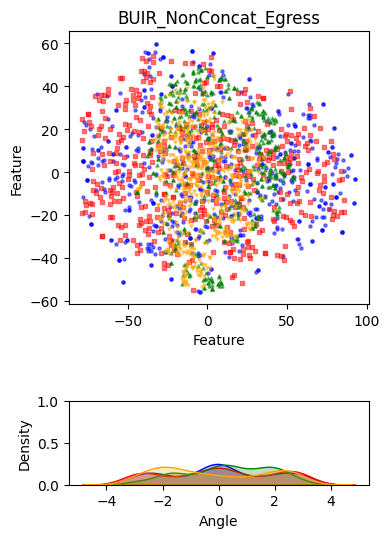

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
from sklearn.manifold import TSNE
import seaborn as sns
import random

np.random.seed(42)
random.seed(42)
torch.manual_seed(42)

# Load data
train_data = pd.read_csv('./dataset/douban-book/train.txt', delim_whitespace=True, header=None, names=['user_id', 'item_id', 'interaction'])
test_data = pd.read_csv('./dataset/douban-book/test.txt', delim_whitespace=True, header=None, names=['user_id', 'item_id', 'interaction'])
# user_emb = torch.load('./embedding/base/SelfCF_douban-book/best_user_emb.pt', map_location=torch.device('cpu'))
# item_emb = torch.load('./embedding/base/SelfCF_douban-book/best_item_emb.pt', map_location=torch.device('cpu'))

best_p_u = torch.load('./embedding/NonConcat_Egress/BUIR_NonConcat_Egress/douban-book/best_p_u.pt', map_location=torch.device('cpu'))
best_u = torch.load('./embedding/NonConcat_Egress/BUIR_NonConcat_Egress/douban-book/best_u.pt', map_location=torch.device('cpu'))
best_p_i = torch.load('./embedding/NonConcat_Egress/BUIR_NonConcat_Egress/douban-book/best_p_i.pt', map_location=torch.device('cpu'))
best_i = torch.load('./embedding/NonConcat_Egress/BUIR_NonConcat_Egress/douban-book/best_i.pt', map_location=torch.device('cpu'))

# Creating combined embeddings
user_emb = best_p_u + best_u
item_emb = best_p_i + best_i

# Calculate popularity
combined_data = pd.concat([train_data, test_data])
user_popularity = combined_data.groupby('user_id')['interaction'].sum().reset_index()
item_popularity = combined_data.groupby('item_id')['interaction'].sum().reset_index()

# Define thresholds for hot and cold sampling
user_hot_threshold = user_popularity['interaction'].quantile(0.95)
user_cold_threshold = user_popularity['interaction'].quantile(0.80)
item_hot_threshold = item_popularity['interaction'].quantile(0.95)
item_cold_threshold = item_popularity['interaction'].quantile(0.80)

# Sample hot and cold users/items
hot_users = user_popularity[user_popularity['interaction'] > user_hot_threshold].sample(500, replace=True)
cold_users = user_popularity[user_popularity['interaction'] <= user_cold_threshold].sample(500, replace=True)
hot_items = item_popularity[item_popularity['interaction'] > item_hot_threshold].sample(500, replace=True)
cold_items = item_popularity[item_popularity['interaction'] <= item_cold_threshold].sample(500, replace=True)

# Ensure that user and item ids are within the valid index range
valid_user_ids = hot_users['user_id'].apply(lambda x: x < user_emb.shape[0])
valid_item_ids = hot_items['item_id'].apply(lambda x: x < item_emb.shape[0])

hot_users = hot_users[valid_user_ids]
hot_items = hot_items[valid_item_ids]

valid_user_ids = cold_users['user_id'].apply(lambda x: x < user_emb.shape[0])
valid_item_ids = cold_items['item_id'].apply(lambda x: x < item_emb.shape[0])

cold_users = cold_users[valid_user_ids]
cold_items = cold_items[valid_item_ids]

# Now extract embeddings
hot_user_emb = user_emb[hot_users['user_id'].values]
cold_user_emb = user_emb[cold_users['user_id'].values]
hot_item_emb = item_emb[hot_items['item_id'].values]
cold_item_emb = item_emb[cold_items['item_id'].values]



# Combine and map to 2D using t-SNE
combined_user_emb = torch.cat([hot_user_emb, cold_user_emb])
combined_item_emb = torch.cat([hot_item_emb, cold_item_emb])
tsne = TSNE(n_components=2, random_state=42)
# user_emb_2d = tsne.fit_transform(combined_user_emb)
user_emb_2d = tsne.fit_transform(combined_user_emb.detach().numpy())
item_emb_2d = tsne.fit_transform(combined_item_emb.detach().numpy())

angles_hot_users = np.arctan2(user_emb_2d[:500, 1], user_emb_2d[:500, 0])
angles_cold_users = np.arctan2(user_emb_2d[500:, 1], user_emb_2d[500:, 0])
angles_hot_items = np.arctan2(item_emb_2d[:500, 1], item_emb_2d[:500, 0])
angles_cold_items = np.arctan2(item_emb_2d[500:, 1], item_emb_2d[500:, 0])

# Create a new figure for both the scatter and KDE plots
plt.figure(figsize=(4, 6))

plt.subplot(2, 1, 1)
plt.scatter(user_emb_2d[:500, 0], user_emb_2d[:500, 1], s=5, alpha=0.5, label='Hot Users', color='blue', marker='o')
plt.scatter(user_emb_2d[500:, 0], user_emb_2d[500:, 1], s=5, alpha=0.5, label='Cold Users', color='red', marker='s')
plt.scatter(item_emb_2d[:500, 0], item_emb_2d[:500, 1], s=5, alpha=0.5, label='Hot Items', color='green', marker='^')
plt.scatter(item_emb_2d[500:, 0], item_emb_2d[500:, 1], s=5, alpha=0.5, label='Cold Items', color='orange', marker='v')

plt.title("BUIR_NonConcat_Egress")
plt.xlabel("Feature")
plt.ylabel("Feature")
# plt.legend()

# Plot KDE for angles
plt.subplot(2, 1, 2, aspect=3)
sns.kdeplot(angles_hot_users, fill=True, color='blue', label='Hot Users')  # dark gray
sns.kdeplot(angles_cold_users, fill=True, color='red', label='Cold Users')  # medium-dark gray
sns.kdeplot(angles_hot_items, fill=True, color='green', label='Hot Items')  # medium-light gray
sns.kdeplot(angles_cold_items, fill=True, color='orange', label='Cold Items')  # light gray

# Labeling the plot
# plt.title("KDE of atan2(y, x) for Each Group")
plt.xlabel("Angle")
plt.ylabel("Density")
plt.ylim(0, 1)
# plt.legend()

plt.tight_layout()
plt.savefig('/Users/mean/Downloads/ThinGCN/embedding/NonConcat_Egress/BUIR_NonConcat_Egress/douban-book/BUIR_NonConcat_Egress.png')
plt.show()

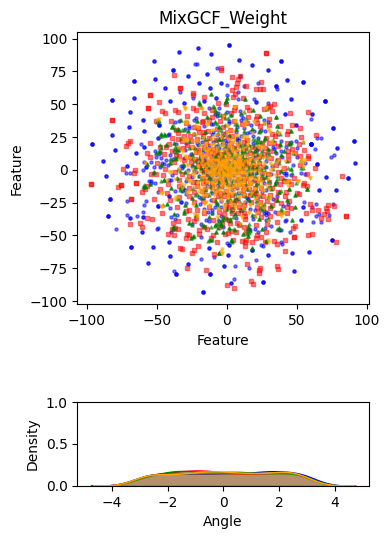

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
from sklearn.manifold import TSNE
import seaborn as sns
import random

np.random.seed(42)
random.seed(42)
torch.manual_seed(42)

# Load data
train_data = pd.read_csv('./dataset/douban-book/train.txt', delim_whitespace=True, header=None, names=['user_id', 'item_id', 'interaction'])
test_data = pd.read_csv('./dataset/douban-book/test.txt', delim_whitespace=True, header=None, names=['user_id', 'item_id', 'interaction'])
user_emb = torch.load('./embedding/Weight/MixGCF_Weight/douban-book/best_user_emb.pt', map_location=torch.device('cpu'))
item_emb = torch.load('./embedding/Weight/MixGCF_Weight/douban-book/best_item_emb.pt', map_location=torch.device('cpu'))

# Calculate popularity
combined_data = pd.concat([train_data, test_data])
user_popularity = combined_data.groupby('user_id')['interaction'].sum().reset_index()
item_popularity = combined_data.groupby('item_id')['interaction'].sum().reset_index()

# Define thresholds for hot and cold sampling
user_hot_threshold = user_popularity['interaction'].quantile(0.95)
user_cold_threshold = user_popularity['interaction'].quantile(0.80)
item_hot_threshold = item_popularity['interaction'].quantile(0.95)
item_cold_threshold = item_popularity['interaction'].quantile(0.80)

# Sample hot and cold users/items
hot_users = user_popularity[user_popularity['interaction'] > user_hot_threshold].sample(500, replace=True)
cold_users = user_popularity[user_popularity['interaction'] <= user_cold_threshold].sample(500, replace=True)
hot_items = item_popularity[item_popularity['interaction'] > item_hot_threshold].sample(500, replace=True)
cold_items = item_popularity[item_popularity['interaction'] <= item_cold_threshold].sample(500, replace=True)

# Ensure that user and item ids are within the valid index range
valid_user_ids = hot_users['user_id'].apply(lambda x: x < user_emb.shape[0])
valid_item_ids = hot_items['item_id'].apply(lambda x: x < item_emb.shape[0])

hot_users = hot_users[valid_user_ids]
hot_items = hot_items[valid_item_ids]

valid_user_ids = cold_users['user_id'].apply(lambda x: x < user_emb.shape[0])
valid_item_ids = cold_items['item_id'].apply(lambda x: x < item_emb.shape[0])

cold_users = cold_users[valid_user_ids]
cold_items = cold_items[valid_item_ids]

# Now extract embeddings
hot_user_emb = user_emb[hot_users['user_id'].values]
cold_user_emb = user_emb[cold_users['user_id'].values]
hot_item_emb = item_emb[hot_items['item_id'].values]
cold_item_emb = item_emb[cold_items['item_id'].values]



# Combine and map to 2D using t-SNE
combined_user_emb = torch.cat([hot_user_emb, cold_user_emb])
combined_item_emb = torch.cat([hot_item_emb, cold_item_emb])
tsne = TSNE(n_components=2, random_state=42)
# user_emb_2d = tsne.fit_transform(combined_user_emb)
user_emb_2d = tsne.fit_transform(combined_user_emb.detach().numpy())
item_emb_2d = tsne.fit_transform(combined_item_emb.detach().numpy())

angles_hot_users = np.arctan2(user_emb_2d[:500, 1], user_emb_2d[:500, 0])
angles_cold_users = np.arctan2(user_emb_2d[500:, 1], user_emb_2d[500:, 0])
angles_hot_items = np.arctan2(item_emb_2d[:500, 1], item_emb_2d[:500, 0])
angles_cold_items = np.arctan2(item_emb_2d[500:, 1], item_emb_2d[500:, 0])

# Create a new figure for both the scatter and KDE plots
plt.figure(figsize=(4, 6))

plt.subplot(2, 1, 1)
plt.scatter(user_emb_2d[:500, 0], user_emb_2d[:500, 1], s=5, alpha=0.5, label='Hot Users', color='blue', marker='o')
plt.scatter(user_emb_2d[500:, 0], user_emb_2d[500:, 1], s=5, alpha=0.5, label='Cold Users', color='red', marker='s')
plt.scatter(item_emb_2d[:500, 0], item_emb_2d[:500, 1], s=5, alpha=0.5, label='Hot Items', color='green', marker='^')
plt.scatter(item_emb_2d[500:, 0], item_emb_2d[500:, 1], s=5, alpha=0.5, label='Cold Items', color='orange', marker='v')

plt.title("MixGCF_Weight")
plt.xlabel("Feature")
plt.ylabel("Feature")
# plt.legend()

# Plot KDE for angles
plt.subplot(2, 1, 2, aspect=3)
sns.kdeplot(angles_hot_users, fill=True, color='blue', label='Hot Users')  # dark gray
sns.kdeplot(angles_cold_users, fill=True, color='red', label='Cold Users')  # medium-dark gray
sns.kdeplot(angles_hot_items, fill=True, color='green', label='Hot Items')  # medium-light gray
sns.kdeplot(angles_cold_items, fill=True, color='orange', label='Cold Items')  # light gray

# Labeling the plot
# plt.title("KDE of atan2(y, x) for Each Group")
plt.xlabel("Angle")
plt.ylabel("Density")
plt.ylim(0, 1)
# plt.legend()

plt.tight_layout()
plt.savefig('/Users/mean/Downloads/ThinGCN/embedding/Weight/MixGCF_Weight/douban-book/MixGCF_Weight.png')
plt.show()

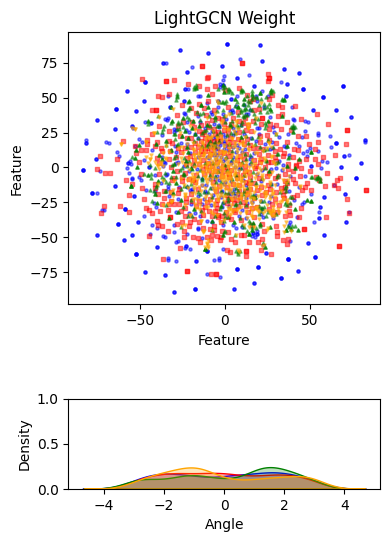

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
from sklearn.manifold import TSNE
import seaborn as sns
import random

np.random.seed(42)
random.seed(42)
torch.manual_seed(42)

# Load data
train_data = pd.read_csv('c:\\Users\\admin\\Downloads\\ThinGCN\\dataset\\douban-book\\train.txt', delim_whitespace=True, header=None, names=['user_id', 'item_id', 'interaction'])
test_data = pd.read_csv('c:\\Users\\admin\\Downloads\\ThinGCN\\dataset\\douban-book\\test.txt', delim_whitespace=True, header=None, names=['user_id', 'item_id', 'interaction'])
user_emb = torch.load('c:\\Users\\admin\\Downloads\\ThinGCN\\embedding\\Weight\\LightGCN_Weight\\douban-book\\best_user_emb.pt', map_location=torch.device('cpu'))
item_emb = torch.load('c:\\Users\\admin\\Downloads\\ThinGCN\\embedding\\Weight\\LightGCN_Weight\\douban-book\\best_item_emb.pt', map_location=torch.device('cpu'))
# C:\Users\admin\Downloads\ThinGCN\embedding\Weight_Egress\LightGCN_Weight_Egress\ml-1m\best_item_emb.pt
# Calculate popularity
combined_data = pd.concat([train_data, test_data])
user_popularity = combined_data.groupby('user_id')['interaction'].sum().reset_index()
item_popularity = combined_data.groupby('item_id')['interaction'].sum().reset_index()

# Define thresholds for hot and cold sampling
user_hot_threshold = user_popularity['interaction'].quantile(0.95)
user_cold_threshold = user_popularity['interaction'].quantile(0.80)
item_hot_threshold = item_popularity['interaction'].quantile(0.95)
item_cold_threshold = item_popularity['interaction'].quantile(0.80)

# Sample hot and cold users/items
hot_users = user_popularity[user_popularity['interaction'] > user_hot_threshold].sample(500, replace=True)
cold_users = user_popularity[user_popularity['interaction'] <= user_cold_threshold].sample(500, replace=True)
hot_items = item_popularity[item_popularity['interaction'] > item_hot_threshold].sample(500, replace=True)
cold_items = item_popularity[item_popularity['interaction'] <= item_cold_threshold].sample(500, replace=True)

# Ensure that user and item ids are within the valid index range
valid_user_ids = hot_users['user_id'].apply(lambda x: x < user_emb.shape[0])
valid_item_ids = hot_items['item_id'].apply(lambda x: x < item_emb.shape[0])

hot_users = hot_users[valid_user_ids]
hot_items = hot_items[valid_item_ids]

valid_user_ids = cold_users['user_id'].apply(lambda x: x < user_emb.shape[0])
valid_item_ids = cold_items['item_id'].apply(lambda x: x < item_emb.shape[0])

cold_users = cold_users[valid_user_ids]
cold_items = cold_items[valid_item_ids]

# Now extract embeddings
hot_user_emb = user_emb[hot_users['user_id'].values]
cold_user_emb = user_emb[cold_users['user_id'].values]
hot_item_emb = item_emb[hot_items['item_id'].values]
cold_item_emb = item_emb[cold_items['item_id'].values]



# Combine and map to 2D using t-SNE
combined_user_emb = torch.cat([hot_user_emb, cold_user_emb])
combined_item_emb = torch.cat([hot_item_emb, cold_item_emb])
tsne = TSNE(n_components=2, random_state=42)
# user_emb_2d = tsne.fit_transform(combined_user_emb)
user_emb_2d = tsne.fit_transform(combined_user_emb.detach().numpy())
item_emb_2d = tsne.fit_transform(combined_item_emb.detach().numpy())

angles_hot_users = np.arctan2(user_emb_2d[:500, 1], user_emb_2d[:500, 0])
angles_cold_users = np.arctan2(user_emb_2d[500:, 1], user_emb_2d[500:, 0])
angles_hot_items = np.arctan2(item_emb_2d[:500, 1], item_emb_2d[:500, 0])
angles_cold_items = np.arctan2(item_emb_2d[500:, 1], item_emb_2d[500:, 0])

# Create a new figure for both the scatter and KDE plots
plt.figure(figsize=(4, 6))

plt.subplot(2, 1, 1)
plt.scatter(user_emb_2d[:500, 0], user_emb_2d[:500, 1], s=5, alpha=0.5, label='Hot Users', color='blue', marker='o')
plt.scatter(user_emb_2d[500:, 0], user_emb_2d[500:, 1], s=5, alpha=0.5, label='Cold Users', color='red', marker='s')
plt.scatter(item_emb_2d[:500, 0], item_emb_2d[:500, 1], s=5, alpha=0.5, label='Hot Items', color='green', marker='^')
plt.scatter(item_emb_2d[500:, 0], item_emb_2d[500:, 1], s=5, alpha=0.5, label='Cold Items', color='orange', marker='v')

plt.title("LightGCN Weight")
plt.xlabel("Feature")
plt.ylabel("Feature")
# plt.legend()

# Plot KDE for angles
plt.subplot(2, 1, 2, aspect=3)
sns.kdeplot(angles_hot_users, fill=True, color='blue', label='Hot Users')  # dark gray
sns.kdeplot(angles_cold_users, fill=True, color='red', label='Cold Users')  # medium-dark gray
sns.kdeplot(angles_hot_items, fill=True, color='green', label='Hot Items')  # medium-light gray
sns.kdeplot(angles_cold_items, fill=True, color='orange', label='Cold Items')  # light gray

# Labeling the plot
# plt.title("KDE of atan2(y, x) for Each Group")
plt.xlabel("Angle")
plt.ylabel("Density")
plt.ylim(0, 1)
# plt.legend()

plt.tight_layout()
plt.savefig('c:\\Users\\admin\\Downloads\\ThinGCN\\embedding\\Weight\\LightGCN_Weight\\douban-book\\LightGCN_Weight.png')
plt.show()

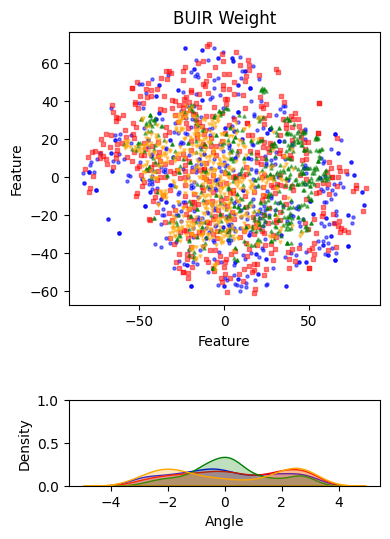

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
from sklearn.manifold import TSNE
import seaborn as sns
import random

np.random.seed(42)
random.seed(42)
torch.manual_seed(42)

# Load data
train_data = pd.read_csv('c:\\Users\\admin\\Downloads\\ThinGCN\\dataset\\douban-book\\train.txt', delim_whitespace=True, header=None, names=['user_id', 'item_id', 'interaction'])
test_data = pd.read_csv('c:\\Users\\admin\\Downloads\\ThinGCN\\dataset\\douban-book\\test.txt', delim_whitespace=True, header=None, names=['user_id', 'item_id', 'interaction'])
# user_emb = torch.load('c:\\Users\\admin\\Downloads\\ThinGCN\\embedding\\Weight\\BUIR_Weight\\douban-book\\best_user_emb.pt', map_location=torch.device('cpu'))
# item_emb = torch.load('c:\\Users\\admin\\Downloads\\ThinGCN\\embedding\\Weight\\BUIR_Weight\\douban-book\\best_item_emb.pt', map_location=torch.device('cpu'))

best_p_u = torch.load('c:\\Users\\admin\\Downloads\\ThinGCN\\embedding\\Weight\\BUIR_Weight\\douban-book\\best_p_u.pt', map_location=torch.device('cpu'))
best_u = torch.load('c:\\Users\\admin\\Downloads\\ThinGCN\\embedding\\Weight\\BUIR_Weight\\douban-book\\best_u.pt', map_location=torch.device('cpu'))
best_p_i = torch.load('c:\\Users\\admin\\Downloads\\ThinGCN\\embedding\\Weight\\BUIR_Weight\\douban-book\\best_p_i.pt', map_location=torch.device('cpu'))
best_i = torch.load('c:\\Users\\admin\\Downloads\\ThinGCN\\embedding\\Weight\\BUIR_Weight\\douban-book\\best_i.pt', map_location=torch.device('cpu'))

# Creating combined embeddings
user_emb = best_p_u + best_u
item_emb = best_p_i + best_i

# Calculate popularity
combined_data = pd.concat([train_data, test_data])
user_popularity = combined_data.groupby('user_id')['interaction'].sum().reset_index()
item_popularity = combined_data.groupby('item_id')['interaction'].sum().reset_index()

# Define thresholds for hot and cold sampling
user_hot_threshold = user_popularity['interaction'].quantile(0.95)
user_cold_threshold = user_popularity['interaction'].quantile(0.80)
item_hot_threshold = item_popularity['interaction'].quantile(0.95)
item_cold_threshold = item_popularity['interaction'].quantile(0.80)

# Sample hot and cold users/items
hot_users = user_popularity[user_popularity['interaction'] > user_hot_threshold].sample(500, replace=True)
cold_users = user_popularity[user_popularity['interaction'] <= user_cold_threshold].sample(500, replace=True)
hot_items = item_popularity[item_popularity['interaction'] > item_hot_threshold].sample(500, replace=True)
cold_items = item_popularity[item_popularity['interaction'] <= item_cold_threshold].sample(500, replace=True)

# Ensure that user and item ids are within the valid index range
valid_user_ids = hot_users['user_id'].apply(lambda x: x < user_emb.shape[0])
valid_item_ids = hot_items['item_id'].apply(lambda x: x < item_emb.shape[0])

hot_users = hot_users[valid_user_ids]
hot_items = hot_items[valid_item_ids]

valid_user_ids = cold_users['user_id'].apply(lambda x: x < user_emb.shape[0])
valid_item_ids = cold_items['item_id'].apply(lambda x: x < item_emb.shape[0])

cold_users = cold_users[valid_user_ids]
cold_items = cold_items[valid_item_ids]

# Now extract embeddings
hot_user_emb = user_emb[hot_users['user_id'].values]
cold_user_emb = user_emb[cold_users['user_id'].values]
hot_item_emb = item_emb[hot_items['item_id'].values]
cold_item_emb = item_emb[cold_items['item_id'].values]



# Combine and map to 2D using t-SNE
combined_user_emb = torch.cat([hot_user_emb, cold_user_emb])
combined_item_emb = torch.cat([hot_item_emb, cold_item_emb])
tsne = TSNE(n_components=2, random_state=42)
# user_emb_2d = tsne.fit_transform(combined_user_emb)
user_emb_2d = tsne.fit_transform(combined_user_emb.detach().numpy())
item_emb_2d = tsne.fit_transform(combined_item_emb.detach().numpy())

angles_hot_users = np.arctan2(user_emb_2d[:500, 1], user_emb_2d[:500, 0])
angles_cold_users = np.arctan2(user_emb_2d[500:, 1], user_emb_2d[500:, 0])
angles_hot_items = np.arctan2(item_emb_2d[:500, 1], item_emb_2d[:500, 0])
angles_cold_items = np.arctan2(item_emb_2d[500:, 1], item_emb_2d[500:, 0])

# Create a new figure for both the scatter and KDE plots
plt.figure(figsize=(4, 6))

plt.subplot(2, 1, 1)
plt.scatter(user_emb_2d[:500, 0], user_emb_2d[:500, 1], s=5, alpha=0.5, label='Hot Users', color='blue', marker='o')
plt.scatter(user_emb_2d[500:, 0], user_emb_2d[500:, 1], s=5, alpha=0.5, label='Cold Users', color='red', marker='s')
plt.scatter(item_emb_2d[:500, 0], item_emb_2d[:500, 1], s=5, alpha=0.5, label='Hot Items', color='green', marker='^')
plt.scatter(item_emb_2d[500:, 0], item_emb_2d[500:, 1], s=5, alpha=0.5, label='Cold Items', color='orange', marker='v')

plt.title("BUIR Weight")
plt.xlabel("Feature")
plt.ylabel("Feature")
# plt.legend()

# Plot KDE for angles
plt.subplot(2, 1, 2, aspect=3)
sns.kdeplot(angles_hot_users, fill=True, color='blue', label='Hot Users')  # dark gray
sns.kdeplot(angles_cold_users, fill=True, color='red', label='Cold Users')  # medium-dark gray
sns.kdeplot(angles_hot_items, fill=True, color='green', label='Hot Items')  # medium-light gray
sns.kdeplot(angles_cold_items, fill=True, color='orange', label='Cold Items')  # light gray

# Labeling the plot
# plt.title("KDE of atan2(y, x) for Each Group")
plt.xlabel("Angle")
plt.ylabel("Density")
plt.ylim(0, 1)
# plt.legend()

plt.tight_layout()
plt.savefig('c:\\Users\\admin\\Downloads\\ThinGCN\\embedding\\Weight\\BUIR_Weight\\douban-book\\BUIR_Weight.png')
plt.show()

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
from sklearn.manifold import TSNE
import seaborn as sns
import random

# Create a figure and axis for legend only
fig_legend, ax_legend = plt.subplots(figsize=(2, 2))

# Create dummy scatter plots for legend
ax_legend.scatter([], [], s=5, alpha=0.5, label='Hot Users', color='blue', marker='o')
ax_legend.scatter([], [], s=5, alpha=0.5, label='Cold Users', color='red', marker='s')
ax_legend.scatter([], [], s=5, alpha=0.5, label='Hot Items', color='green', marker='^')
ax_legend.scatter([], [], s=5, alpha=0.5, label='Cold Items', color='orange', marker='v')

# Draw the legend on the axis
legend = ax_legend.legend(loc='center', frameon=False, fontsize=10)
ax_legend.axis('off')

# Save the legend as an image
legend_path = "c:\\Users\\admin\\Downloads\\SelfCF_legend.png"
plt.savefig(legend_path, bbox_inches='tight')
plt.show()

legend_path